<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/PyTorch/Nithin/DLS_Assignment_1_nvaradha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning Systems Fall 2022 Assignment 1

### Nithin Varadharajan (nvaradha)

### Problem 1: A Detailed View to MNIST Classification

**1.1 - 1.2**

Train a fully-connected net for MNIST classification (sorry, no CNN please, yet). It should
be with 5 hidden layers each of which is with 1024 hidden units. Feel free to use whatever
techniques you learned in class. You should be able to get the test accuracy above 98%.




In [149]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt

In [150]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


Speed Test

In [151]:
# PyTorch
Nlist=[5, 1000, 3000]
T=10
timeDiffNP=np.zeros((T,len(Nlist)), dtype=np.float32)
timeDiffTF=np.zeros((T,len(Nlist)), dtype=np.float32)
for N in range(len(Nlist)):
    A=np.random.rand(Nlist[N],Nlist[N])
    Atf=torch.randn(Nlist[N],Nlist[N]).cuda()
    
    for i in range(T):
        ticNP=time.time()
        B=A@A@A@A@A
        tocNP=time.time()
        

        ticTF=time.time()
        Btf=Atf@Atf@Atf@Atf@Atf
        tocTF=time.time()    
        timeDiffNP[i,N]=tocNP-ticNP
        timeDiffTF[i,N]=tocTF-ticTF    

In [152]:
for N in range(len(Nlist)):
    print('{0}X{0}: {1:f}'.format(Nlist[N], np.mean(timeDiffNP[:, N], axis=0)))
    print('{0}X{0}: {1:f}'.format(Nlist[N], np.mean(timeDiffTF[:, N], axis=0)))

5X5: 0.000013
5X5: 0.000093
1000X1000: 0.199443
1000X1000: 0.000257
3000X3000: 5.224269
3000X3000: 0.000266


In [153]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [154]:
# Get Datasets
import torchvision
mnist_train=torchvision.datasets.MNIST('mnist',
                                      train=True,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor(),
                                                                                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                                                ]))

mnist_test=torchvision.datasets.MNIST('mnist',
                                      train=False,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor(),
                                                                                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                                                ]))


In [155]:
#Reading number of samples in each set
n_train = len(mnist_train)
n_test = len(mnist_test)

print(n_train)
print(n_test)

60000
10000


In [156]:
# Set Hyperparameters
n_epochs = 200 # max_epochs
batch_size_train = 100 # batch size train set
batch_size_test = 100 # batch size test set
learning_rate = 0.001 # learn rate
log_interval = 5 # log every _ epoch

patience = 15  # epochs after which training should stop if no improvement


In [157]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size_test, shuffle=True)

In [158]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(784, 1024)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.output = nn.Linear(1024, 10)
        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        # self.LeakyReLU = nn.LeakyReLU(leaky_relu_a)
        # self.Dropout = nn.Dropout(p=dropout)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.ReLU(x)

        x = self.fc1(x)
        x = self.ReLU(x)

        x = self.fc2(x)
        x = self.ReLU(x)

        x = self.fc3(x)
        x = self.ReLU(x)

        x = self.fc4(x)
        x = self.ReLU(x)

        x = self.fc5(x)
        x = self.ReLU(x)

        x = self.output(x)
        #x = F.softmax(x, dim = 1)
        return x




In [159]:
# Access my Google Drive

# from google.colab import drive
# drive.mount('/content/gdrive')

In [160]:
# If saved model is present load it, and test the accuracy

from torch.utils.data import TensorDataset, DataLoader

# model2 = Network().to(device)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)

# checkpoint = torch.load('/content/gdrive/My Drive/DLS_Assignments/a1q1.pt')
# model2.load_state_dict(checkpoint['model_state_dict'])
# optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

# # model2 = torch.load('/content/gdrive/My Drive/DLS_Assignments/a1q1_2.pt')
# # model2 = model2.to(device)

# bst_test_data2 = np.load('/content/gdrive/My Drive/DLS_Assignments/a1q1_bst_test_data.npy')    
# bst_test_labels2 = np.load('/content/gdrive/My Drive/DLS_Assignments/a1q1_bst_test_labels.npy')  

# tensor_x = torch.Tensor(bst_test_data2) # transform to torch tensor
# tensor_y = torch.Tensor(bst_test_labels2)

# my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset

# test_loader2 = torch.utils.data.DataLoader(my_dataset,batch_size=batch_size_test, shuffle=False)


# model2.eval()
# data_list = []
# lbl_list = []
# pred_list = []
# with torch.no_grad():
#   for data, target in test_loader2:
    
#     test_flattened = data.reshape(-1, 784).to(device)
#     test_batch_labels = target.numpy()
#     test_batch_pred = model2.forward(test_flattened).argmax(dim=1, keepdim=True).cpu().numpy()

#     data_list.append(data.numpy())
#     lbl_list.append(test_batch_labels)
#     pred_list.append(test_batch_pred)
    
# data_array = np.concatenate(data_list, axis=0)
# lbl_array = np.concatenate(lbl_list, axis=0)
# pred_array = np.concatenate(pred_list, axis=0)

# model_acc = accuracy_score(lbl_array,pred_array)
# print(model_acc)

In [161]:
import math
# Weight Initialization
# He
# def weight_init(m):
#     if isinstance(m, nn.Linear):
#         nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5), nonlinearity='relu')
#         if m.bias is not None:
#             fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
#             bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
#             nn.init.uniform_(m.bias, -bound, bound)
#             # m.bias.data.fill_(0.0)

# General Weight Init Rule
def weight_init(m):
  if isinstance(m, nn.Linear):
      # get the number of the inputs
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

# Send model to GPU
model = Network().to(device)
model.apply(weight_init)

print(model)



Network(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (ReLU): ReLU()
)


In [162]:
# Define optimizer and loss

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

In [163]:
import numpy as np

# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = 0 # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict)


In [164]:
from sklearn.metrics import accuracy_score

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  stop_training = False # set to stop model training

  patience_rounds = 0 # number of patience rounds
 
  
  print("Training model")

  while ( (stop_training == False) and (epoch <= n_epochs) ):
    
    # Training
    model.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data_flattened = data.reshape(-1,784).to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = model(data_flattened)
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch

    # Evaluation 
    model.eval()
    data_list = []
    lbl_list = []
    pred_list = []
    with torch.no_grad():
      for data, target in test_loader:
        
        test_flattened = data.reshape(-1, 784).to(device)
        test_batch_labels = target.numpy()
        test_batch_pred = F.softmax(model.forward(test_flattened), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()

        data_list.append(data.numpy())
        lbl_list.append(test_batch_labels)
        pred_list.append(test_batch_pred)
        
    data_array = np.concatenate(data_list, axis=0)
    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    epoch_acc = accuracy_score(lbl_array,pred_array)
    
    # Early Stop
    # if acc better than previous
    if(epoch_acc > bst_accuracy):
      # reset patience
      patience_rounds = 0

      # Save result
      bst_accuracy = epoch_acc

      # Save test data
      bst_test_data = data_array
      bst_test_labels = lbl_array
      bst_prediction_array = pred_array
      
      # Save Model
      bst_model = model
      bst_model_state_dict = model.state_dict()
      bst_opt_state_dict = optimizer.state_dict()
      # torch.save(model, 'best_mnist_model.pt')

    # if epoch acc worse
    else:
      # inc patience
      patience_rounds += 1
      if(patience_rounds >= patience):
        stop_training = True
        print("Stopping!")
    
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Epoch Accuracy: {}, Best Accuracy: {} \n ".format(epoch, train_loss, epoch_acc, bst_accuracy))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict)
  return Training_Return


In [165]:
# Train MNIST with test set as validation
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict = res

# Best Model
print("Best Accuracy Model was : {:.2f}".format(bst_accuracy))

Training model
Epoch: 1, Total Training Loss: 186.57388790138066, Epoch Accuracy: 0.9572, Best Accuracy: 0.9572 
 
Epoch: 5, Total Training Loss: 45.09319068863988, Epoch Accuracy: 0.9732, Best Accuracy: 0.9732 
 
Epoch: 10, Total Training Loss: 22.73857110014069, Epoch Accuracy: 0.9801, Best Accuracy: 0.9801 
 
Epoch: 15, Total Training Loss: 22.08509984286502, Epoch Accuracy: 0.9778, Best Accuracy: 0.9801 
 
Epoch: 20, Total Training Loss: 15.391885096527403, Epoch Accuracy: 0.9788, Best Accuracy: 0.9833 
 
Epoch: 25, Total Training Loss: 9.160873585620458, Epoch Accuracy: 0.9835, Best Accuracy: 0.9835 
 
Epoch: 30, Total Training Loss: 7.895800395022945, Epoch Accuracy: 0.9833, Best Accuracy: 0.9835 
 
Epoch: 35, Total Training Loss: 10.87678068334376, Epoch Accuracy: 0.9725, Best Accuracy: 0.9848 
 
Epoch: 40, Total Training Loss: 7.911739303487153, Epoch Accuracy: 0.9837, Best Accuracy: 0.9848 
 
Epoch: 45, Total Training Loss: 7.0585634084251385, Epoch Accuracy: 0.9845, Best Accu

In [172]:
print(bst_accuracy)

0.9866


In [173]:
# Save the model 

# torch.save({
#             'model_state_dict': bst_model_state_dict,
#             'optimizer_state_dict': bst_opt_state_dict,
#             }, '/content/gdrive/My Drive/DLS_Assignments/a1q1.pt')

# torch.save(bst_model, '/content/gdrive/My Drive/DLS_Assignments/a1q1_2.pt')

In [174]:
# Save test data

# np.save('/content/gdrive/My Drive/DLS_Assignments/a1q1_bst_test_data.npy', bst_test_data)    
# np.save('/content/gdrive/My Drive/DLS_Assignments/a1q1_bst_test_labels.npy', bst_test_labels)  

I was able to train my model to get an accuracy above 98% in some runs. It isn't consistently getting over 98% as based on the weight initialization and the randomness in the model it can get stuck in some local minima. I tried to save my model after getting my desired performance.

**1.3**

Do a feedforward step on a thousand test samples. Capture the output of the softmax layer, which will be 10-dim per sample. For each 10-d output vector, find the dim with the maximum probability (which will eventually decide the class label). Plot the input image associated with that in a grid of subplots. For example, you can create a 10 × 10 grid of subplots, whose first row plots first ten input images that produced the highest probabilities for the first dim
(which corresponds to “0”). Eventually, if your classification was near perfect, you’ll see ten 0’s in the first row, ten 1’s in the second, and so on.

In [175]:
# Do feedforward on a 1000 test samples and get softmax output

test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=1000, shuffle=True)

sm_lbls = None
sm_data = None
softmax_out = None

bst_model.eval()
with torch.no_grad():
  for data, target in test_loader:
    
    test_flattened = data.reshape(-1, 784).to(device)

    test_batch_labels = target.numpy()
    test_batch_pred = F.softmax(bst_model.forward(test_flattened), dim = 1).cpu().numpy()

    sm_data = data.numpy()
    sm_lbls = test_batch_labels
    softmax_out = test_batch_pred
    break
  

print(softmax_out.shape)

(1000, 10)


In [176]:
# Do argmax to get max probability index in each 10-d vector
sm_pred = np.argmax(softmax_out, axis=1)

print(sm_pred.shape)
print("Accuracy "+str(accuracy_score(sm_lbls,sm_pred)))

(1000,)
Accuracy 0.984


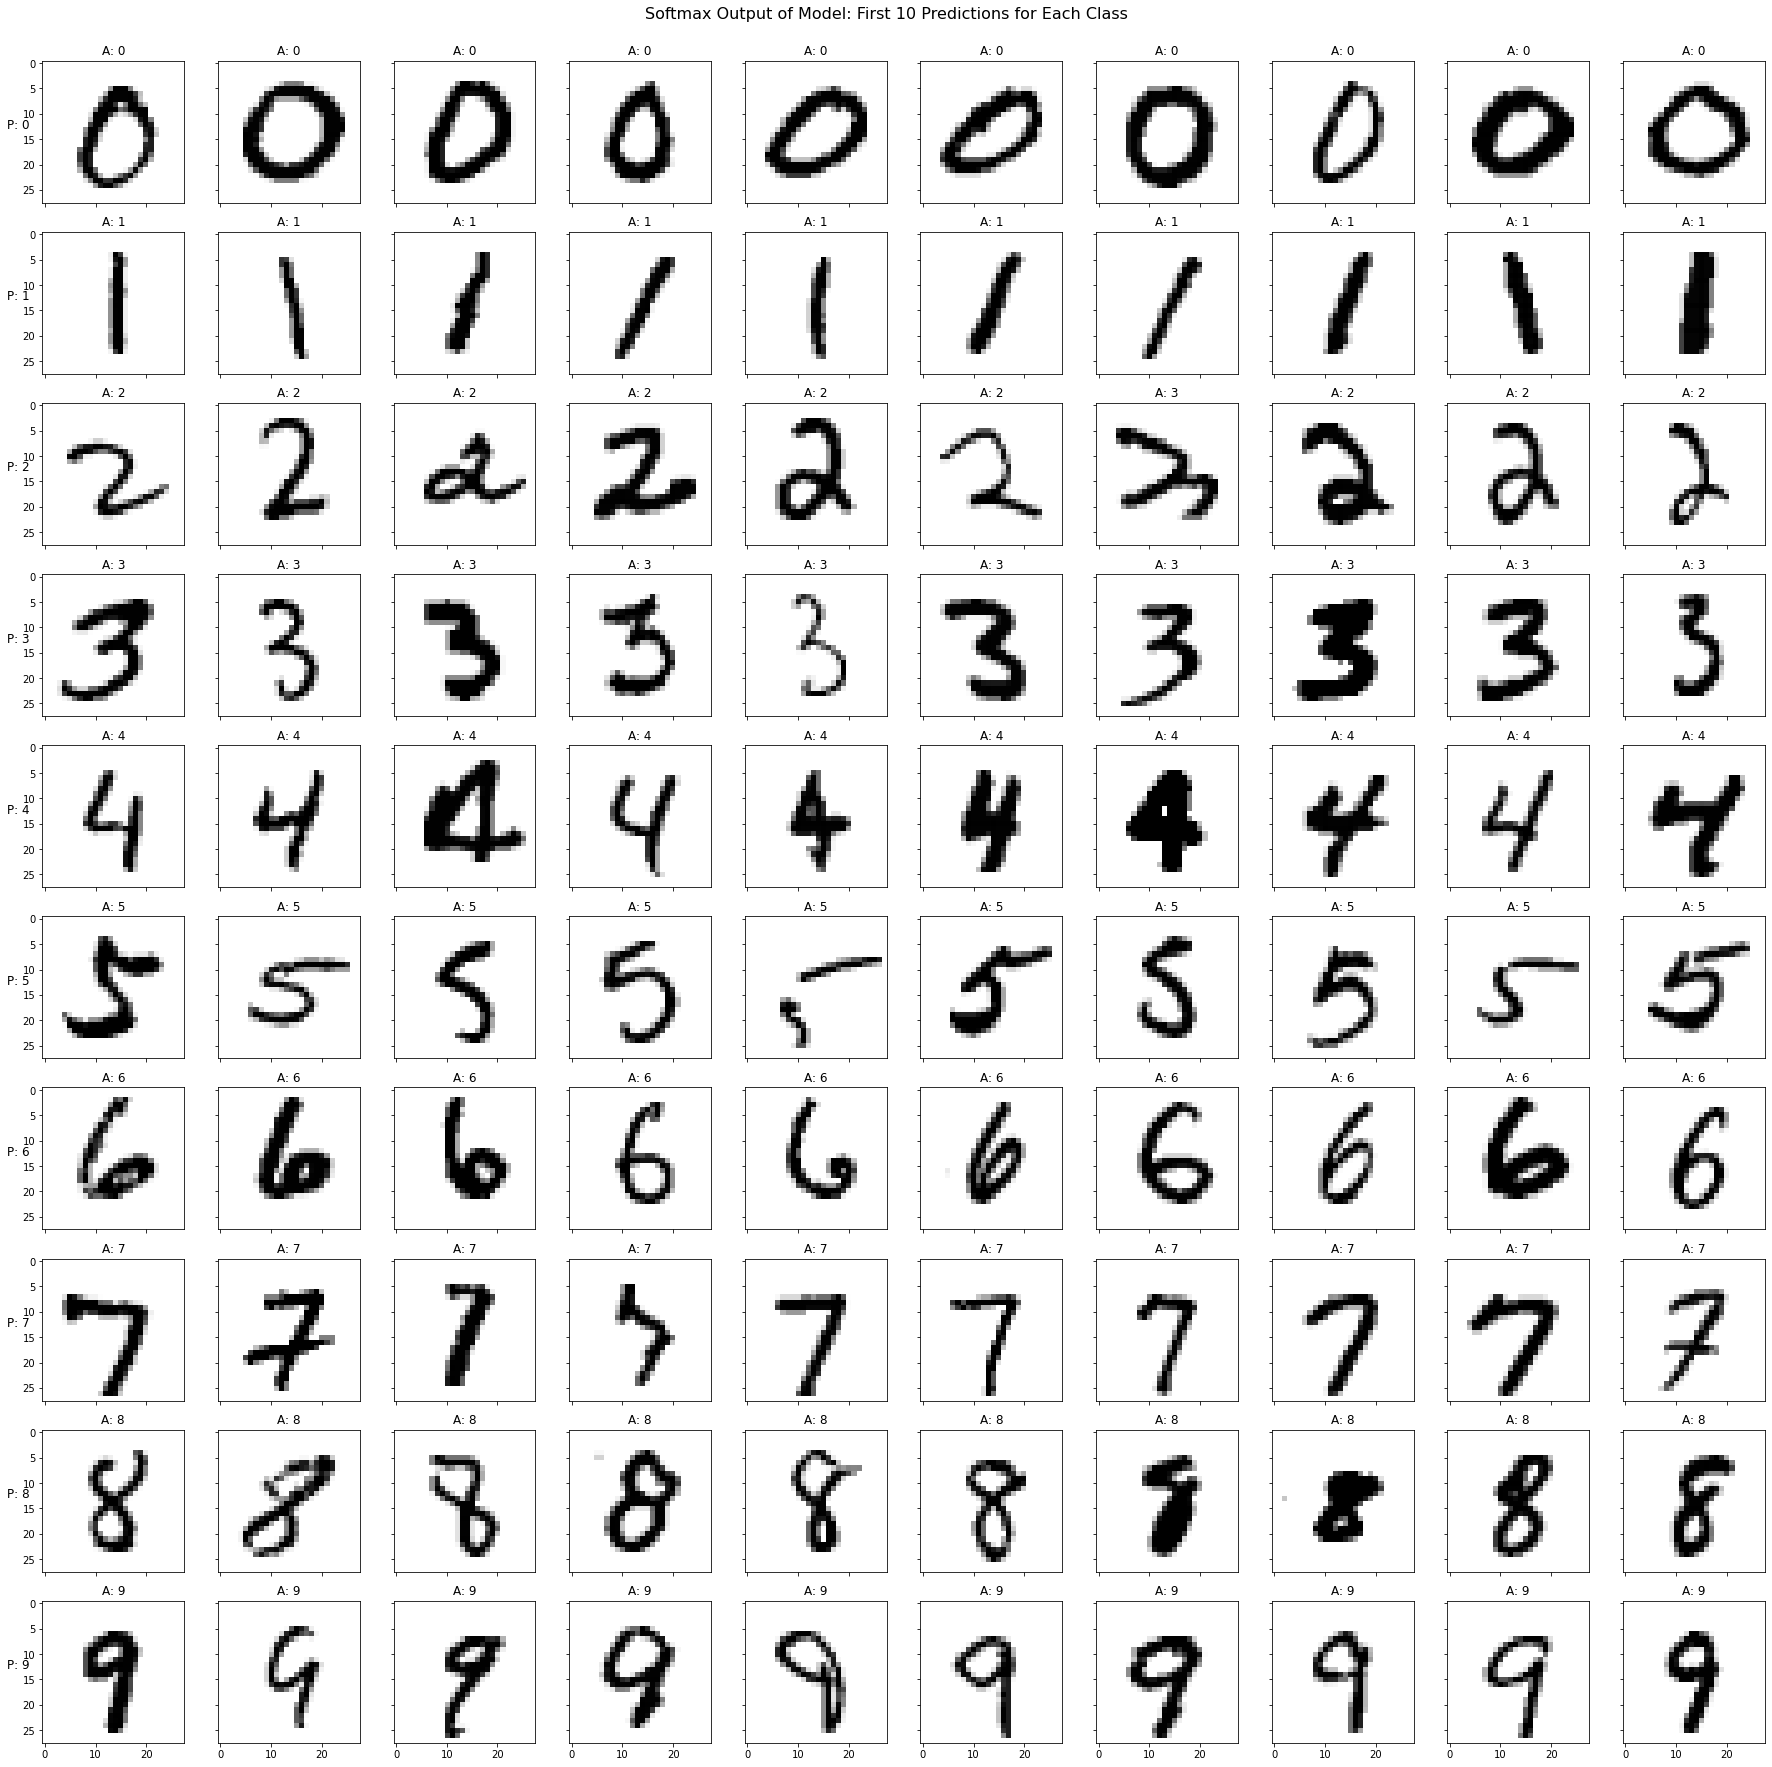

In [177]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize = (25,25))

rows = ['P: {}'.format(row) for row in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]


# for every digit 0-9
for i in range(0,10):

  # get index of first 10 digits with maximum probability at i dim
  x = np.where(sm_pred == i)[0][0:10]

  #get target labels for these chosen samples
  x_lbls = sm_lbls[x] 

  # for the first 10 samples classified as i
  for j in range(len(x)):

    axs[i, j].imshow(sm_data[x][j].reshape(28,28), cmap='gray_r') 
    axs[i, j].set_title('A: {}'.format(x_lbls[j]))



for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Softmax Output of Model: First 10 Predictions for Each Class', fontsize=16) 
fig.tight_layout()
fig.subplots_adjust(top=.95)
plt.show()

**1.4**

Repeat the procedure in Problem 1.3 for your second to the last layer output. Choose 10 random dimensions of interest and repeat the procedure in 1.3 as if the 10 out of 1024 dimensions are your output vectors. Explain your observations 

In [252]:
# Have to redefine model in order to extract info out of intermediate layers

class Network_output(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(784, 1024)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.output = nn.Linear(1024, 10)
        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        # self.LeakyReLU = nn.LeakyReLU(leaky_relu_a)
        # self.Dropout = nn.Dropout(p=dropout)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x0 = self.ReLU(x)

        x = self.fc1(x0)
        x1 = self.ReLU(x)

        x = self.fc2(x1)
        x2 = self.ReLU(x)

        x = self.fc3(x2)
        x3 = self.ReLU(x)

        x = self.fc4(x3)
        x4 = self.ReLU(x)

        x = self.fc5(x4)
        x5 = self.ReLU(x)

        out = self.output(x5)
        #x = F.softmax(x, dim = 1)
        return [x0,x1,x2,x3,x4,x5,out]


In [253]:
# Send model to GPU
# DEfine and send model to GPU
model_out = Network_output().to(device)
model_out.apply(weight_init)

print(model_out)

Network_output(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (ReLU): ReLU()
)


In [255]:
# Load previous weights and bias into new output model
model_out.load_state_dict(bst_model_state_dict)

<All keys matched successfully>

In [263]:
# Do feedforward on a 1000 test samples and get all layers output

test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=1000, shuffle=True)

ll_lbls = None
ll_data = None
output_list = None

model_out.eval()
with torch.no_grad():
  for data, target in test_loader:
    
    test_flattened = data.reshape(-1, 784).to(device)
    test_batch_labels = target.numpy()
    output_list = model_out.forward(test_flattened)

    # create output list of numpy arrays
    for i in range(len(output_list)):
      output_list[i] = output_list[i].cpu().numpy()

    ll_data = data.numpy()
    ll_lbls = test_batch_labels
    break

In [264]:
x0,x1,x2,x3,x4,x5,out = output_list

print(x5.shape)

(1000, 1024)


In [265]:
# Check test accuracy
test123 = torch.Tensor(out)
test_batch_pred = F.softmax(test123, dim = 1).argmax(1).numpy()
print("Accuracy "+str(accuracy_score(ll_lbls,test_batch_pred)))

Accuracy 0.98


In [310]:
# Geenrate 10 random numbers between 0 and 1023 
chosen_dims = np.random.choice(np.array(range(0,1024)),10,replace=False)
print(chosen_dims)

# index new chosen dims from the layer 5 output
new_x5_sample = x5[:,chosen_dims]
print(new_x5_sample.shape)

[657 857 668 165 266 485 277 887 378 895]
(1000, 10)


In [320]:
new_x5_sample[998]

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      , 15.256392,
        0.      ,  0.      ,  0.      ,  0.      ], dtype=float32)

In [311]:
# Getting chosen dimension classification/prediction

# Convert to tensor and call softmax layer followed by an argmax
torch_new_x5_sample = torch.Tensor(new_x5_sample)
x5_pred = F.softmax(torch_new_x5_sample,dim=1).argmax(1).numpy()

print(x5_pred.shape)

(1000,)


In [312]:
# getting counts in x5_preds

unique, counts = np.unique(x5_pred, return_counts=True)

reso_cnts = np.asarray((unique, counts)).T

print(reso_cnts)


[[  0 411]
 [  1  73]
 [  5 516]]


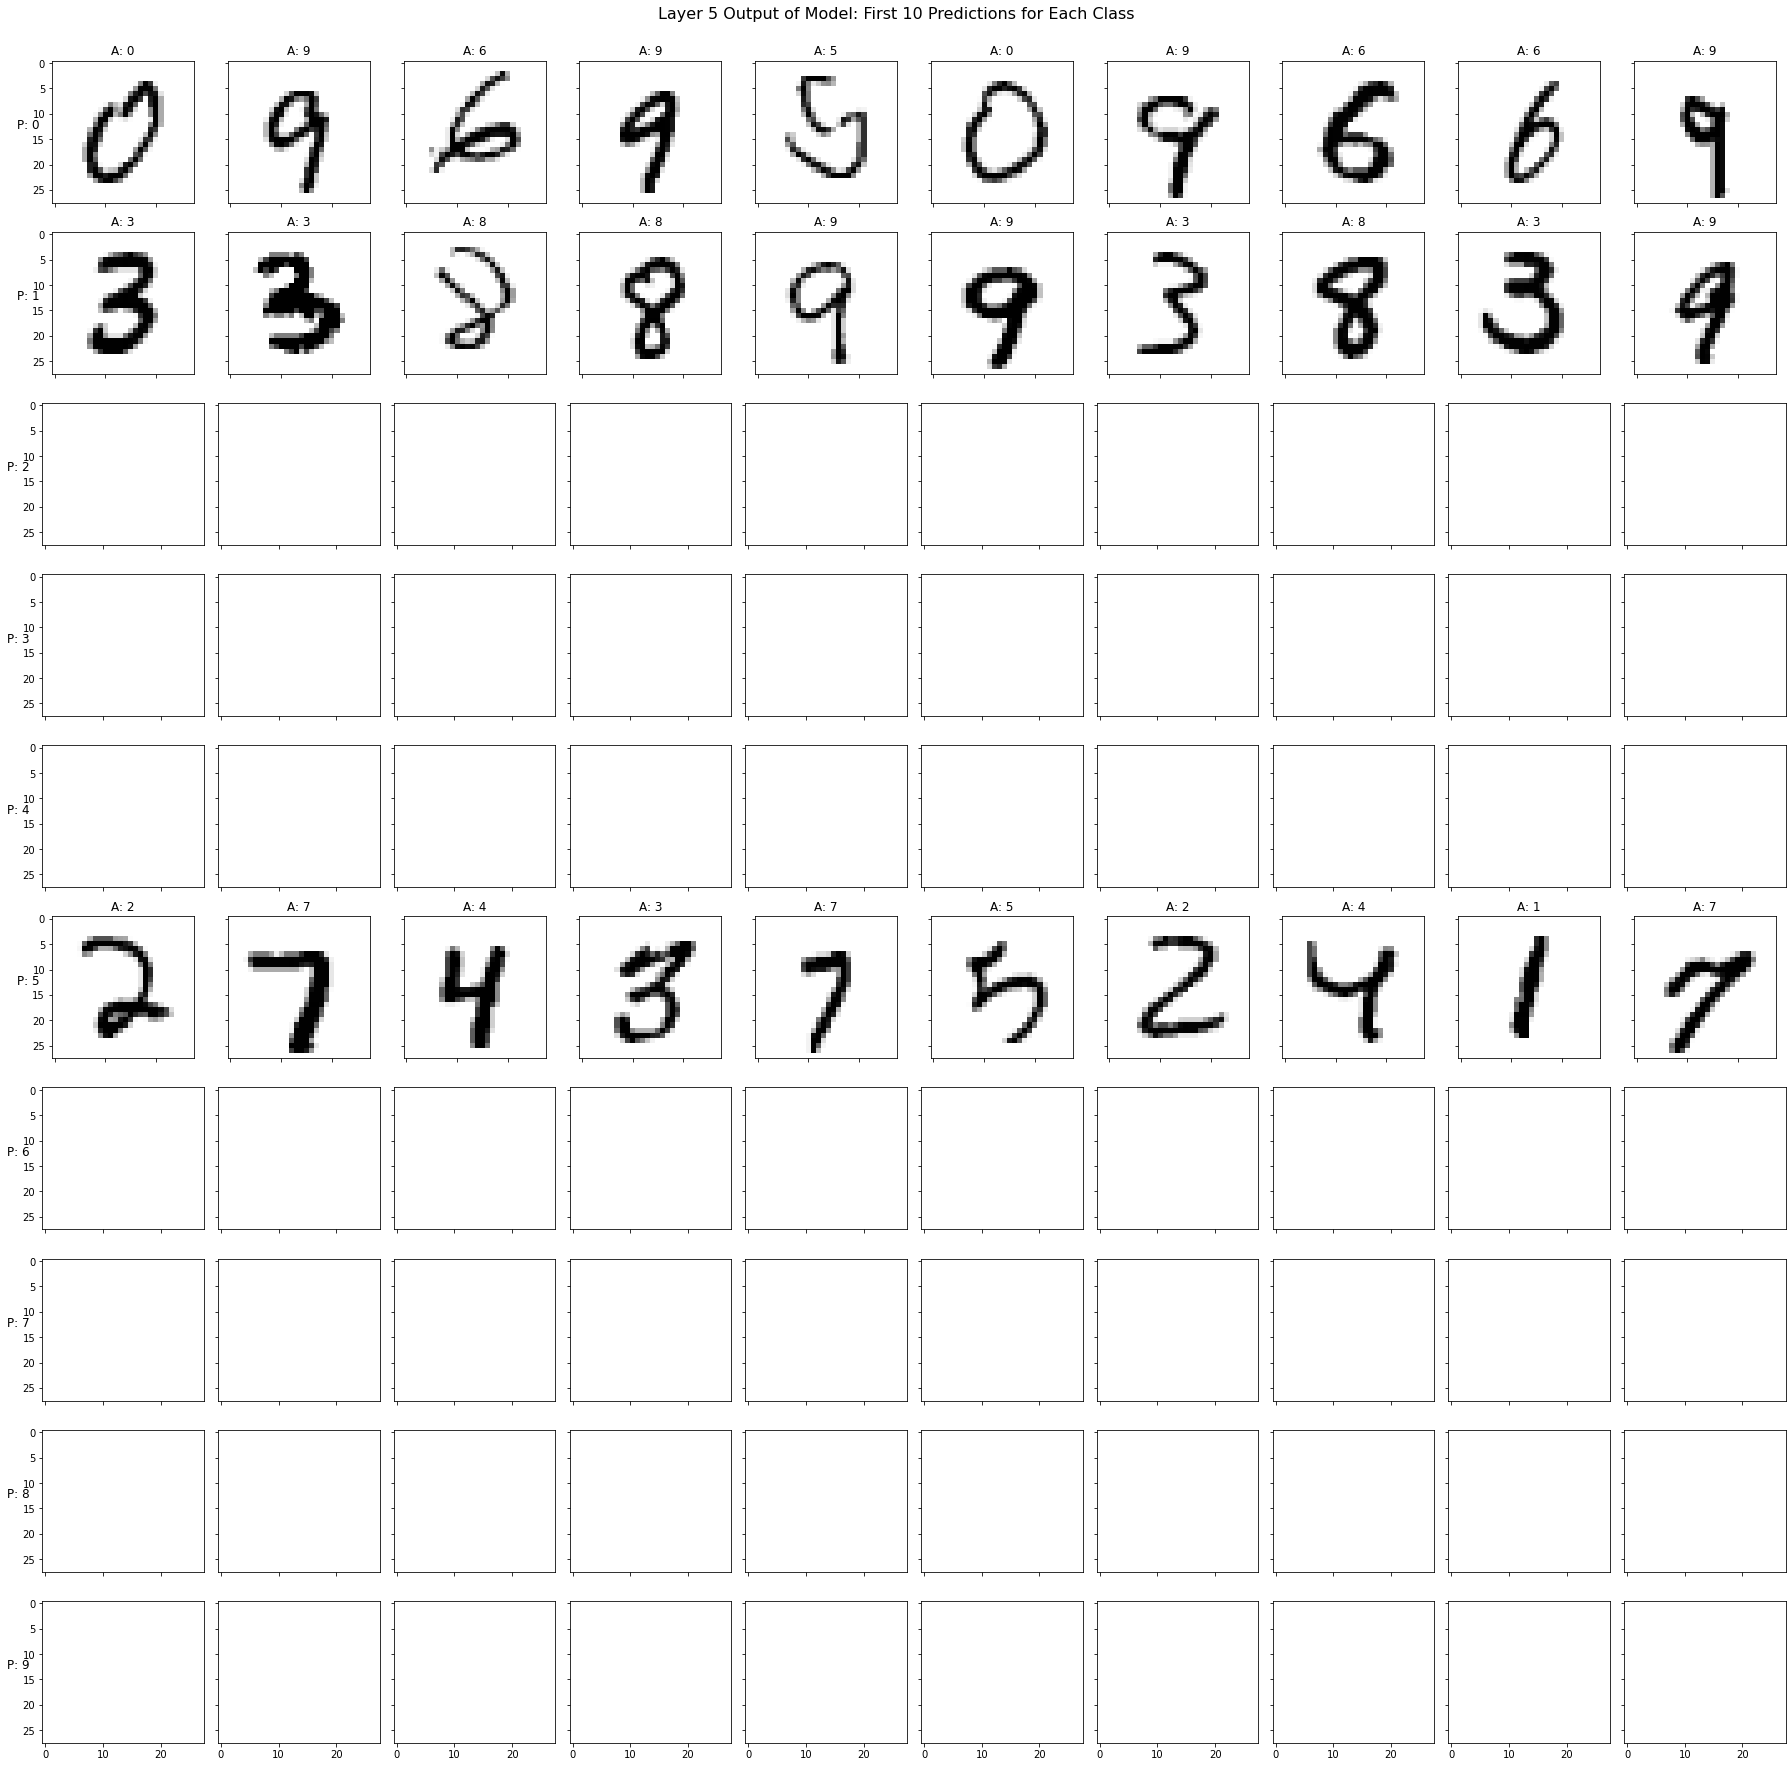

In [313]:
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize = (25,25))

rows = ['P: {}'.format(row) for row in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]


# for every digit in result array
for i in range(len(reso_cnts)):

  digit = reso_cnts[i][0]
  digit_cnt = reso_cnts[i][1]

  num_val = digit_cnt if digit_cnt < 10 else 10

  # get index of first num_val digits with maximum probability at digit
  x = np.where(x5_pred == digit)[0][0:num_val]

  #get target labels for these chosen samples
  x_lbls = ll_lbls[x] 

  # for the first num_val samples classified as digit
  for j in range(len(x)):

    axs[digit, j].imshow(ll_data[x][j].reshape(28,28), cmap='gray_r') 
    axs[digit, j].set_title('A: {}'.format(x_lbls[j]))



for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Layer 5 Output of Model: First 10 Predictions for Each Class', fontsize=16) 
fig.tight_layout()
fig.subplots_adjust(top=.95)
plt.show()

Explain your observation compared with the results from 1.3. What can you see? What would have been the ideal situation for this second-to-the-last layer? Feel free to investigate the other layers if you want, but I wouldn’t care because we have a better way.

Looking at these results, I can see that the output of the softmax layer was a lot better at correctly predicting the target label with accuracy ~98%, but this last layer output when 10 random dims are selected and activated with softmax produces much worse results with close to 0% accuracy. This makes a lot of sense since what we have at the last layer after the relu before the final weight mapping to 10 dimensions, is a 1024 dim feature vector. The final mapping simply decides what features(templates) are important for what class. Here we randomly assign a feature to a dimension, when it might encode something important for another class. What I found is the last layer is pretty sparse with a lot of zero values, so this might mean that only certain templates are important for classification, as can be seen by the empty squares in our graph. The i deal situation is if we randomly picked all the correct features that encode eaxh number and assigned them correctly, but the chances of that are slim, as there are multiple features per class.

**1.5**

t-Stochastic Neighbor Embedding (tSNE) or Principal Component Analysis (PCA) are useful tools to reduce the dimension of your data and visualize. By using them, you can reduce the dimension of your data, for example, down to 2D space, so that you can scatter plot your data samples. 

First, take a thousand test samples from your MNIST dataset. Apply tSNE and PCA on the flattend 784-dim pixels. Now you have 2 × 1000 (or 1000 × 2 if you transposed the data) matrix from each of the dim reduction algorithms. Scatter plot the data samples. USE THE LABELS OF THE DATA SAMPLES SO THAT EACH SET OF SAMPLES FROM THE SAME CLASS ARE REPRESENTED WITH THE SAME COLOR. OVERLAY THE CLASS LABEL ON TOP OF THE MEAN OF THE CLASS. By doing so, you can examine if your data is easy to classify or not. 

In [321]:
# Grab 1000 test samples 

test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size_test, shuffle=True)

embed_lbls = None
embed_data = None

for data, target in test_loader:
  
  test_flattened = data.reshape(-1, 784)
 
  embed_lbls = target.numpy()
  embed_data = test_flattened.numpy()
  break

In [322]:
print(embed_lbls.shape)
print(embed_data.shape)

(100,)
(100, 784)


In [323]:
# Do TSNE Embedding
from sklearn.manifold import TSNE

TSNE_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(embed_data)

print(TSNE_embedded.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(100, 2)


In [324]:
import pandas as pd
import seaborn as sns

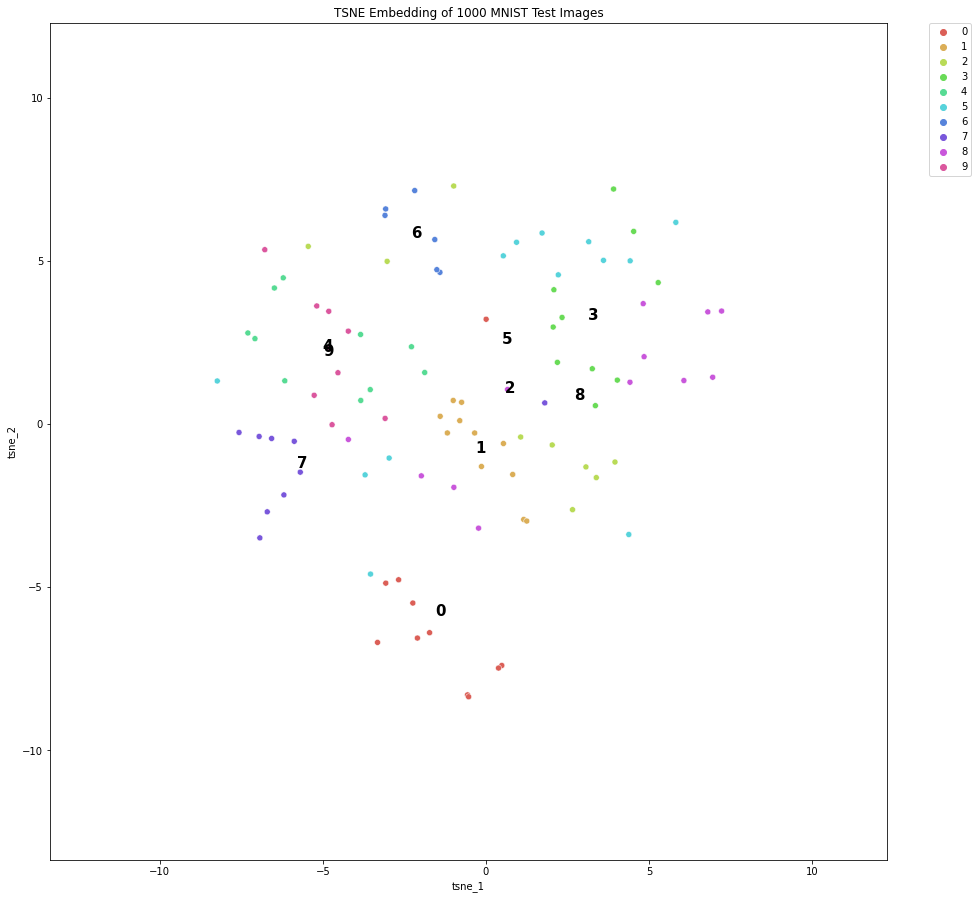

In [325]:
# Plot the result of our TSNE 
tsne_result_df = pd.DataFrame({'tsne_1': TSNE_embedded[:,0], 'tsne_2': TSNE_embedded[:,1], 'label': embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = tsne_result_df[tsne_result_df['label']==i].groupby('label')[list(tsne_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("TSNE Embedding of 1000 MNIST Test Images")
lim = (TSNE_embedded.min()-5, TSNE_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [326]:
print(embed_lbls.shape)
print(embed_data.shape)

(100,)
(100, 784)


In [327]:
# Do PCA Embedding
from sklearn.decomposition import PCA

PCA_embedded = PCA(n_components=2).fit_transform(embed_data)

print(PCA_embedded.shape)

(100, 2)


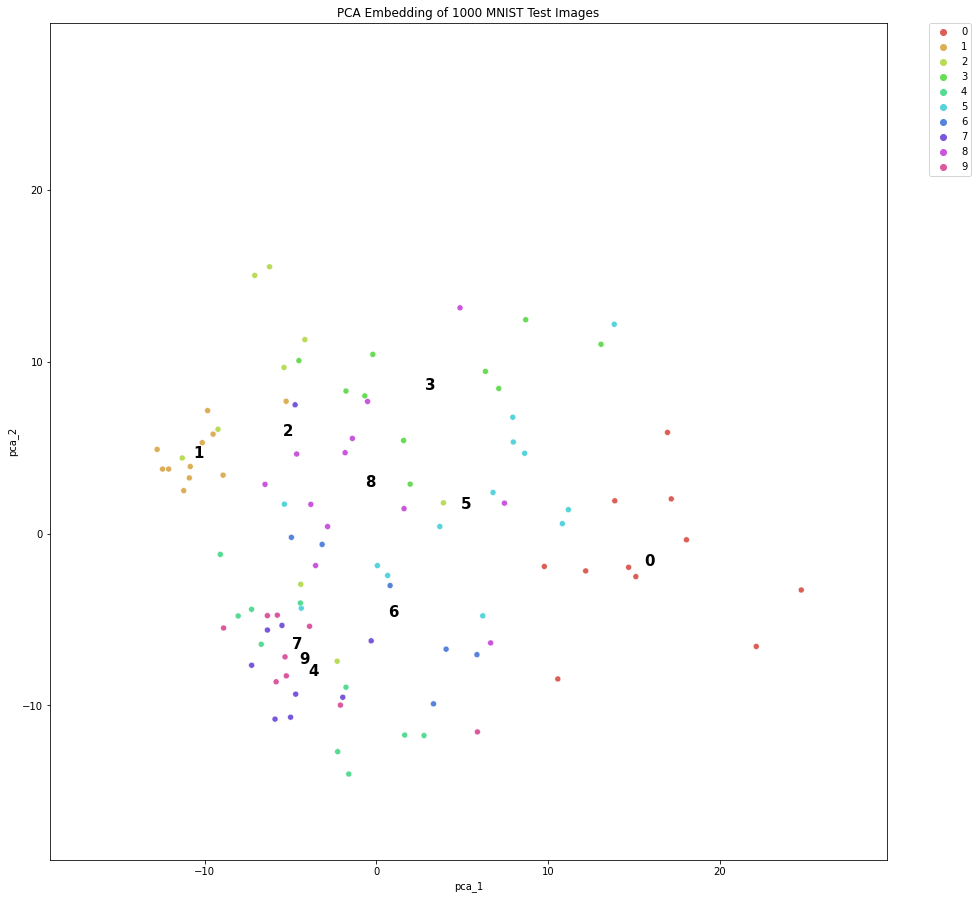

In [328]:
# Plot the result of our PCA
PCA_result_df = pd.DataFrame({'pca_1': PCA_embedded[:,0], 'pca_2': PCA_embedded[:,1], 'label': embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = PCA_result_df[PCA_result_df['label']==i].groupby('label')[list(PCA_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='pca_1', y='pca_2', data=PCA_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("PCA Embedding of 1000 MNIST Test Images")
lim = (PCA_embedded.min()-5, PCA_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

You can examine if your data is easy to classify or not. Do you think this raw image samples are easy to classify? For your information I share my scatter plot of the first two classes in Figure 1. It looks easy because there are only two classes, but with all 10 classes the situation will be different.

Looking at the scatter plot of the 2-d embeddings, it looks like drawing a boundry line to classify these digits simply based on the TSNE or PCA of the images will be hard. The TSNE does look easier as the classes are more clustered, but there is still some overlap. The PCA has some classes that are seperable, but for the msot part the classes are intermixed together. TSNE looks better.

Do a feedforward using your classifier. Capture the output of your first hidden layer, which
will give you 1024 × 1000 matrix. What that means is that you transformed your input
data into a 1024-dim space. You may hope that this makes your classification easier.
Check it out by doing tSNE and PCA on this matrix, which will once again give you 2 × 1000
matrix. Scatter plot and check out if this layer gives you a better representation in terms of
classification.

In [343]:
# Doing a forward pass on a 1000 samples and getting 1st layer output

# Random set of samples
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=1000, shuffle=True)

h_embed_lbls = None
h_embed__data = None
h_embed_output_list = None

model_out.eval()
with torch.no_grad():
  for data, target in test_loader:
    
    test_flattened = data.reshape(-1, 784).to(device)
    test_batch_labels = target.numpy()
    h_embed_output_list = model_out.forward(test_flattened)

    # create output list of numpy arrays
    for i in range(len(h_embed_output_list)):
      h_embed_output_list[i] = h_embed_output_list[i].cpu().numpy()

    h_embed__data = test_flattened.cpu().numpy()
    h_embed_lbls = test_batch_labels
    break


In [344]:
h0,h1,h2,h3,h4,h5,h = h_embed_output_list

print(h1.shape)

(1000, 1024)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


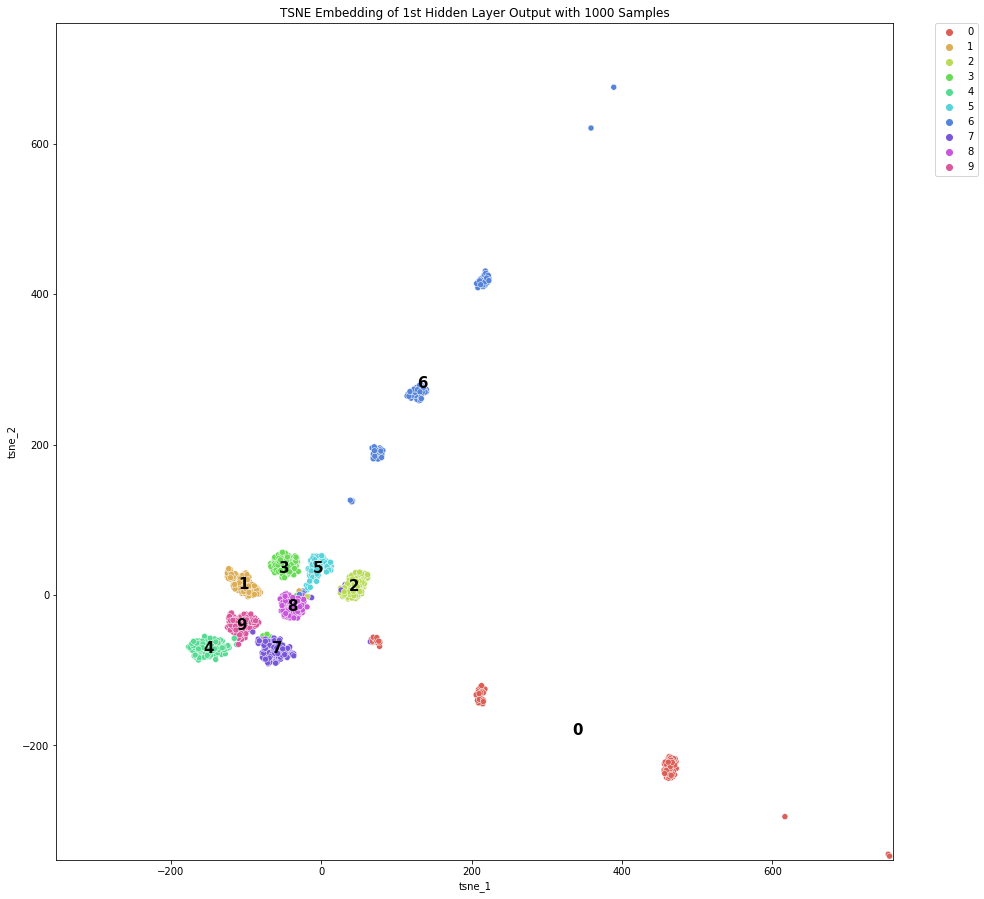

In [345]:
# tSNE on 1st Hidden Layer

TSNE_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(h1)

# Plot the result of our TSNE 
tsne_result_df = pd.DataFrame({'tsne_1': TSNE_embedded[:,0], 'tsne_2': TSNE_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = tsne_result_df[tsne_result_df['label']==i].groupby('label')[list(tsne_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("TSNE Embedding of 1st Hidden Layer Output with 1000 Samples")
lim = (TSNE_embedded.min()-5, TSNE_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

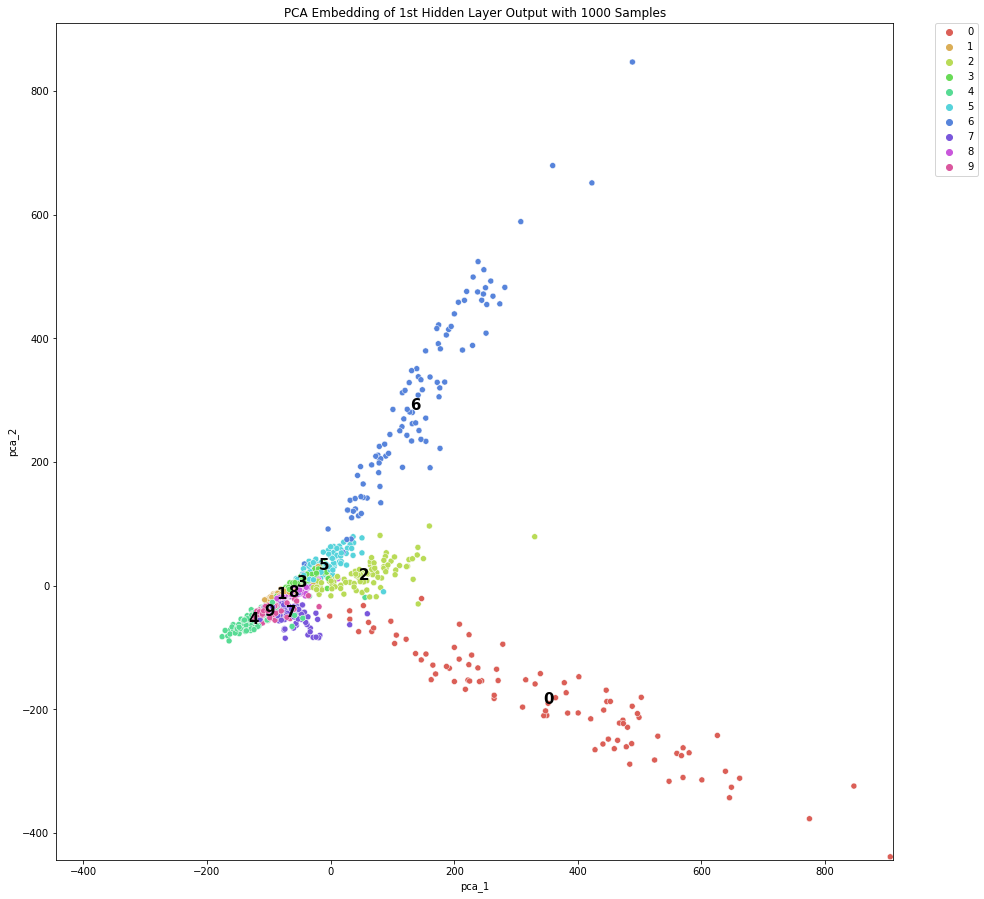

In [346]:
# PCA on 1st Hidden Layer

PCA_embedded = PCA(n_components=2).fit_transform(h1)

# Plot the result of our PCA
PCA_result_df = pd.DataFrame({'pca_1': PCA_embedded[:,0], 'pca_2': PCA_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = PCA_result_df[PCA_result_df['label']==i].groupby('label')[list(PCA_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='pca_1', y='pca_2', data=PCA_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("PCA Embedding of 1st Hidden Layer Output with 1000 Samples")
lim = (PCA_embedded.min()-5, PCA_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)



Comparing the results from the embedding of the input images and the first layer output, shows that the first layer embedding is much more linearly seperable than the input embedding. It gives a much better representation. The TSNE still seperates the classes better than the PCA. In the PCA a lot of classes share embeddings in the first layer.

Repeat this procedure for all your layers including the last one. Explain your observation.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


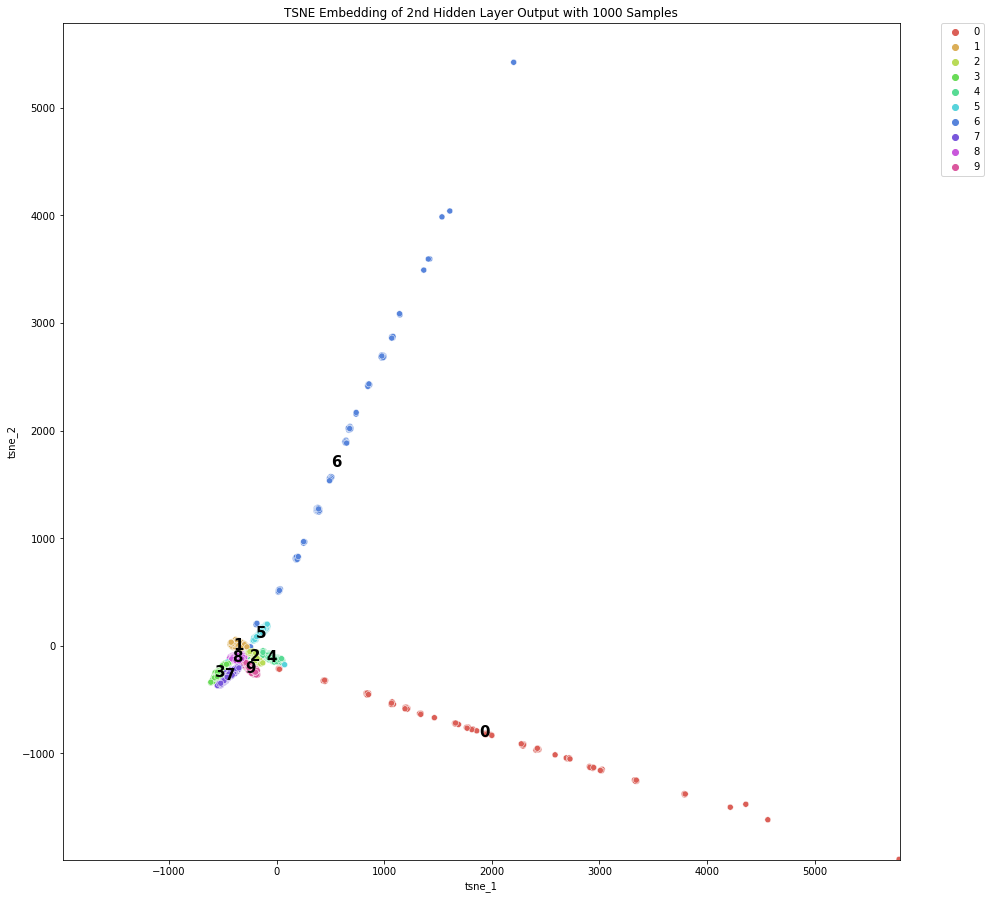

In [347]:
# tSNE on 2nd Hidden Layer

TSNE_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(h2)

# Plot the result of our TSNE 
tsne_result_df = pd.DataFrame({'tsne_1': TSNE_embedded[:,0], 'tsne_2': TSNE_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = tsne_result_df[tsne_result_df['label']==i].groupby('label')[list(tsne_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("TSNE Embedding of 2nd Hidden Layer Output with 1000 Samples")
lim = (TSNE_embedded.min()-5, TSNE_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

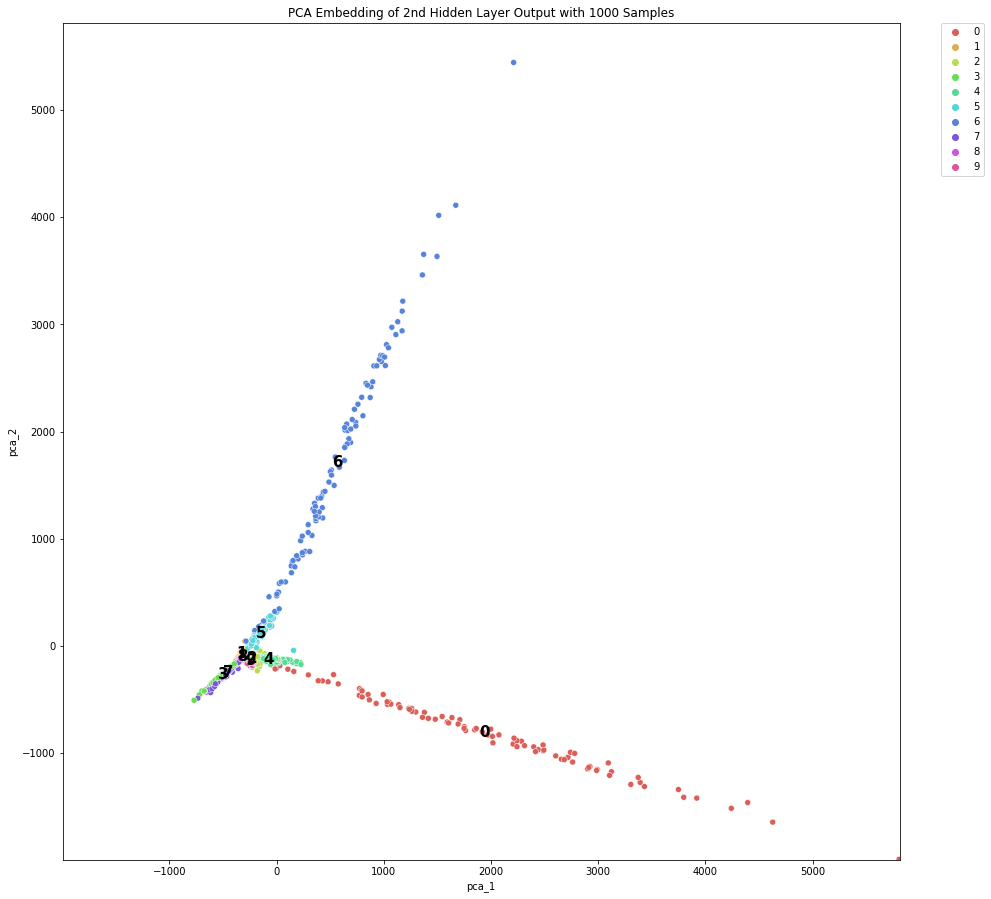

In [348]:
# PCA on 2nd Hidden Layer

PCA_embedded = PCA(n_components=2).fit_transform(h2)

# Plot the result of our PCA
PCA_result_df = pd.DataFrame({'pca_1': PCA_embedded[:,0], 'pca_2': PCA_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = PCA_result_df[PCA_result_df['label']==i].groupby('label')[list(PCA_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='pca_1', y='pca_2', data=PCA_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("PCA Embedding of 2nd Hidden Layer Output with 1000 Samples")
lim = (PCA_embedded.min()-5, PCA_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


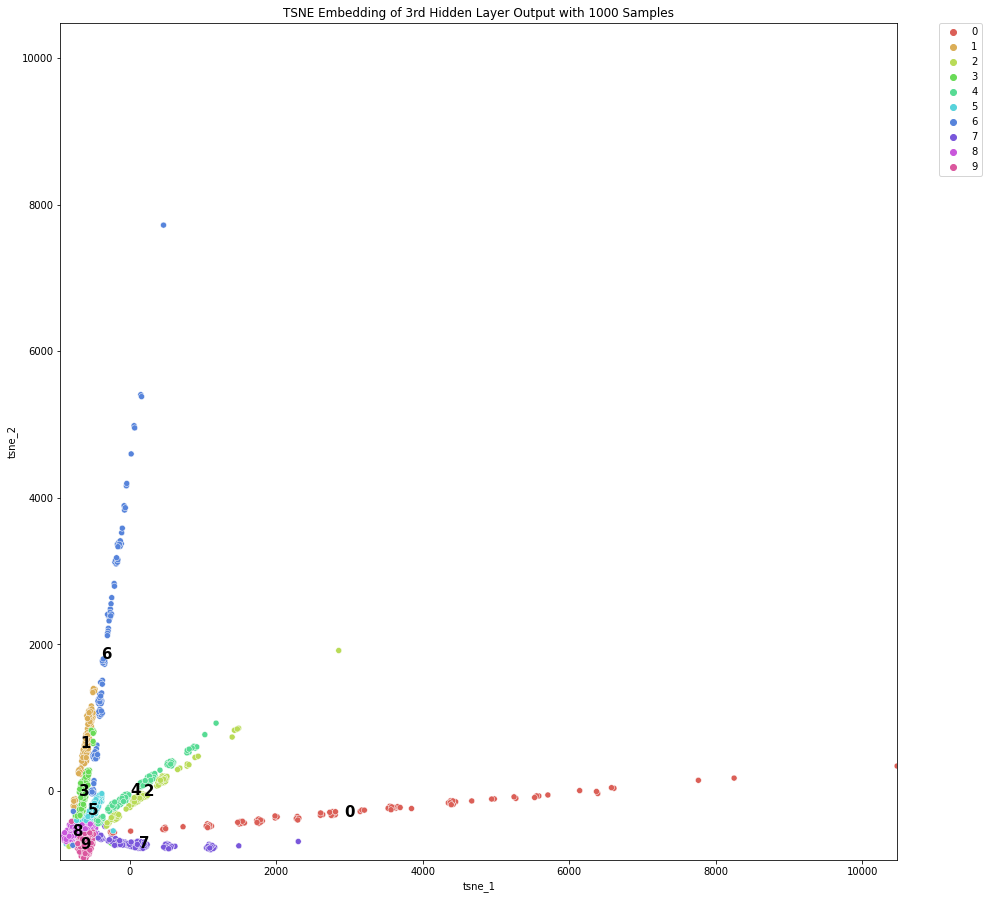

In [349]:
# tSNE on 3rd Hidden Layer

TSNE_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(h3)

# Plot the result of our TSNE 
tsne_result_df = pd.DataFrame({'tsne_1': TSNE_embedded[:,0], 'tsne_2': TSNE_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = tsne_result_df[tsne_result_df['label']==i].groupby('label')[list(tsne_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("TSNE Embedding of 3rd Hidden Layer Output with 1000 Samples")
lim = (TSNE_embedded.min()-5, TSNE_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

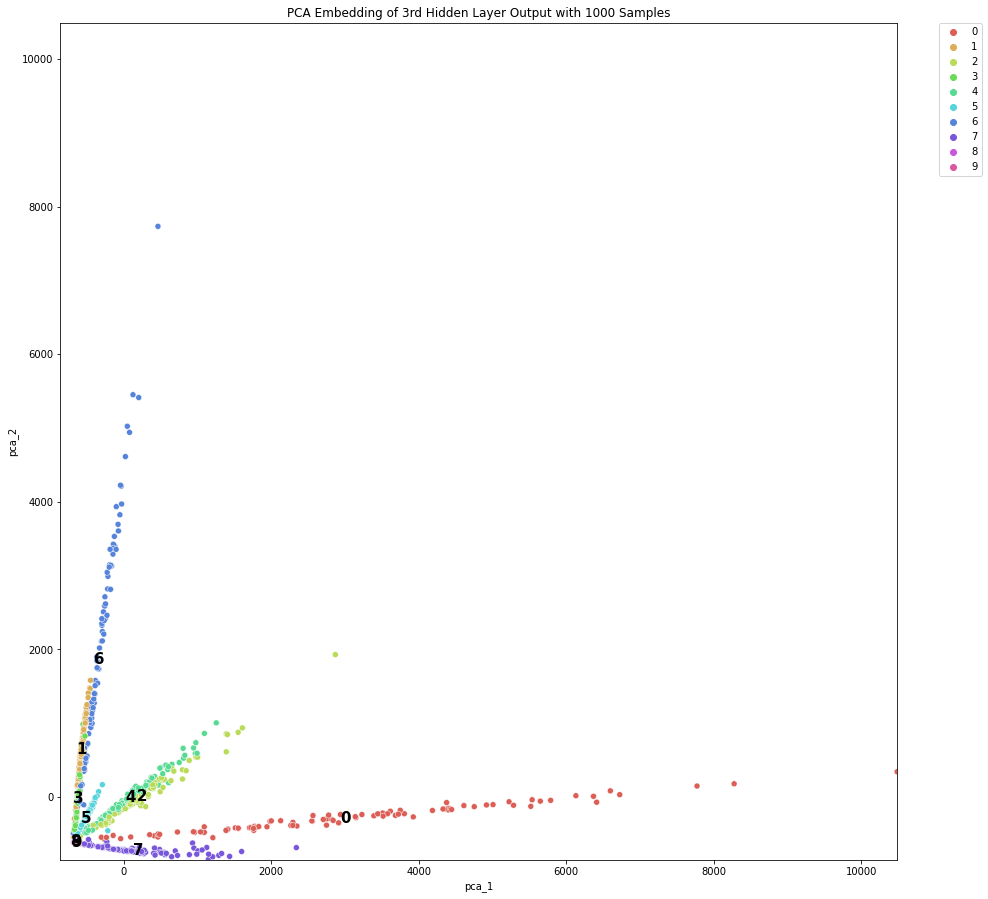

In [350]:
# PCA on 3rd Hidden Layer

PCA_embedded = PCA(n_components=2).fit_transform(h3)

# Plot the result of our PCA
PCA_result_df = pd.DataFrame({'pca_1': PCA_embedded[:,0], 'pca_2': PCA_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = PCA_result_df[PCA_result_df['label']==i].groupby('label')[list(PCA_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='pca_1', y='pca_2', data=PCA_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("PCA Embedding of 3rd Hidden Layer Output with 1000 Samples")
lim = (PCA_embedded.min()-5, PCA_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


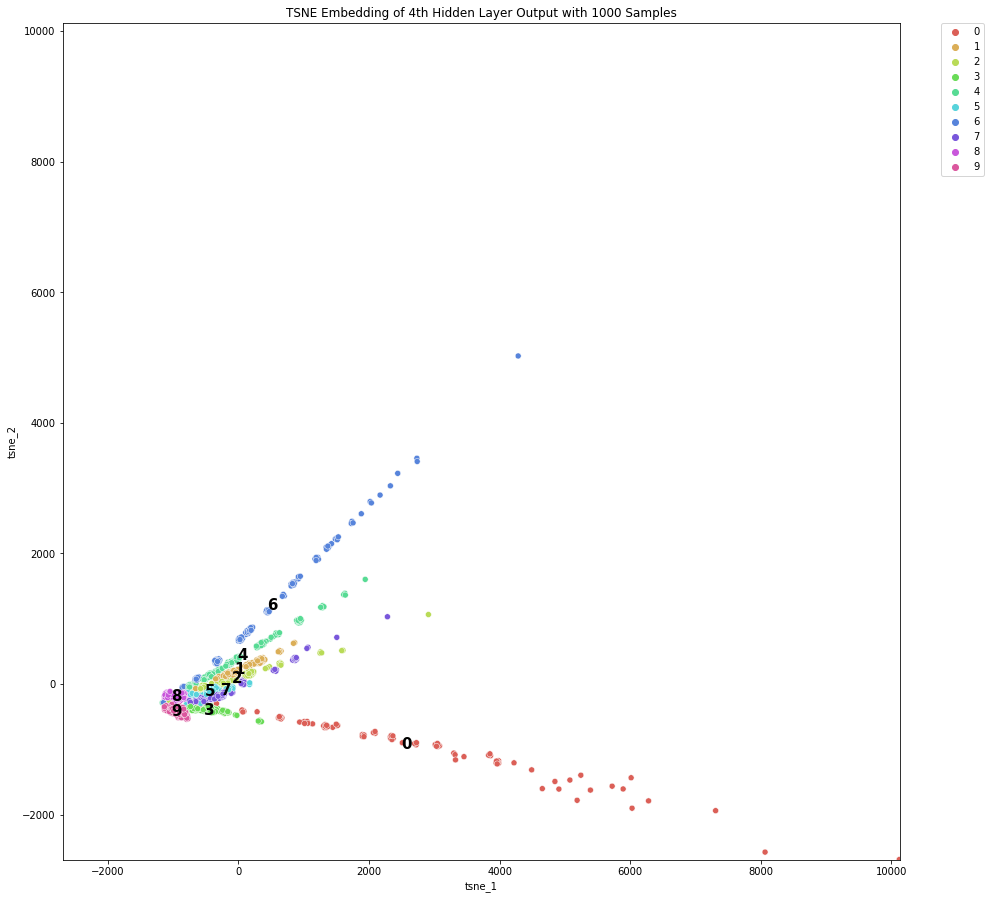

In [351]:
# tSNE on 4th Hidden Layer

TSNE_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(h4)

# Plot the result of our TSNE 
tsne_result_df = pd.DataFrame({'tsne_1': TSNE_embedded[:,0], 'tsne_2': TSNE_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = tsne_result_df[tsne_result_df['label']==i].groupby('label')[list(tsne_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("TSNE Embedding of 4th Hidden Layer Output with 1000 Samples")
lim = (TSNE_embedded.min()-5, TSNE_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

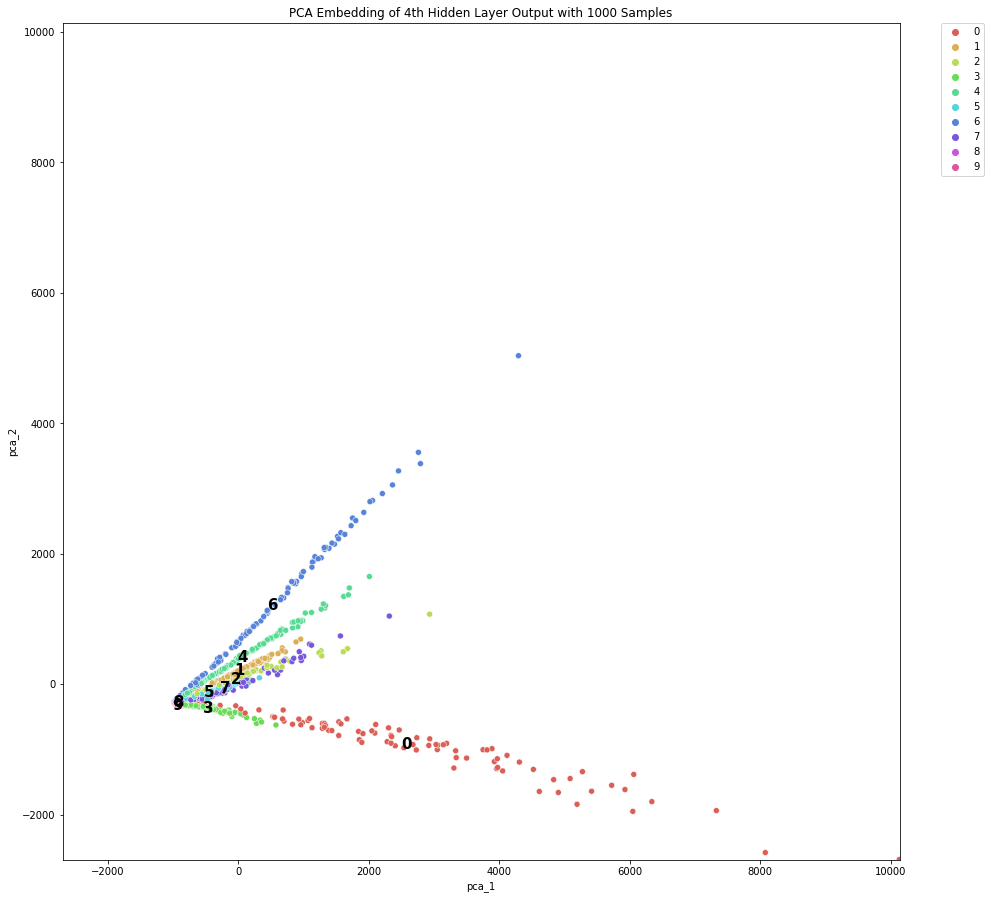

In [352]:
# PCA on 4th Hidden Layer

PCA_embedded = PCA(n_components=2).fit_transform(h4)

# Plot the result of our PCA
PCA_result_df = pd.DataFrame({'pca_1': PCA_embedded[:,0], 'pca_2': PCA_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = PCA_result_df[PCA_result_df['label']==i].groupby('label')[list(PCA_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='pca_1', y='pca_2', data=PCA_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("PCA Embedding of 4th Hidden Layer Output with 1000 Samples")
lim = (PCA_embedded.min()-5, PCA_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


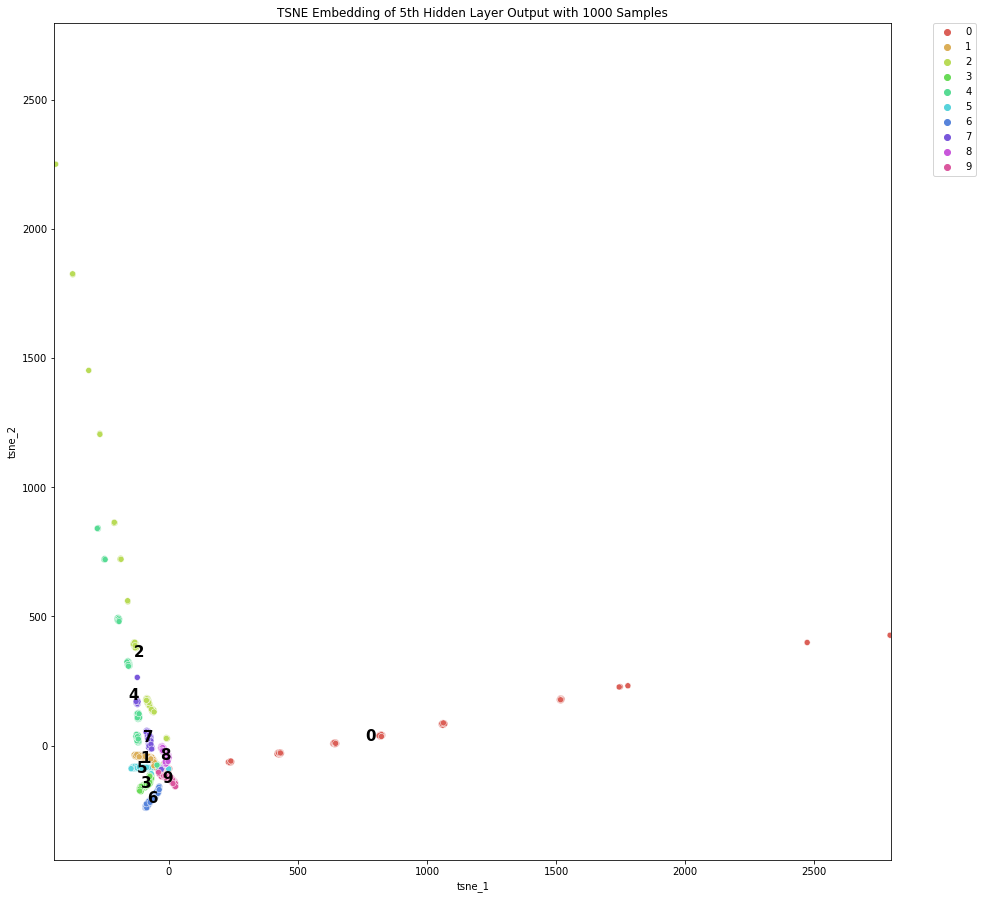

In [353]:
# tSNE on 5th Hidden Layer

TSNE_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(h5)

# Plot the result of our TSNE 
tsne_result_df = pd.DataFrame({'tsne_1': TSNE_embedded[:,0], 'tsne_2': TSNE_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = tsne_result_df[tsne_result_df['label']==i].groupby('label')[list(tsne_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("TSNE Embedding of 5th Hidden Layer Output with 1000 Samples")
lim = (TSNE_embedded.min()-5, TSNE_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

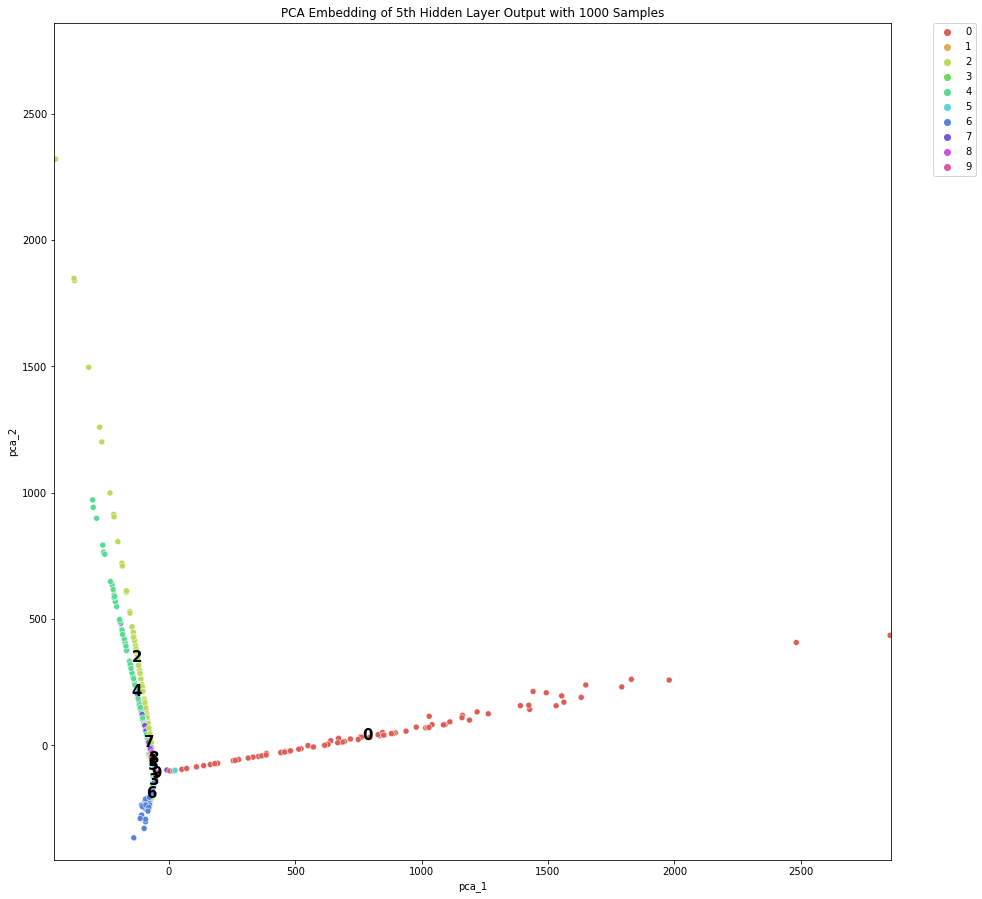

In [354]:
# PCA on 5th Hidden Layer

PCA_embedded = PCA(n_components=2).fit_transform(h5)

# Plot the result of our PCA
PCA_result_df = pd.DataFrame({'pca_1': PCA_embedded[:,0], 'pca_2': PCA_embedded[:,1], 'label': h_embed_lbls})

str_labels = list(map(lambda x: str(x), (np.arange(10)).tolist()))

reso = []
for i in range(10):
  # Get mean of each class
  x = PCA_result_df[PCA_result_df['label']==i].groupby('label')[list(PCA_result_df)[:2]].mean()
  x = x.to_numpy()[0]
  reso.append(x)

means = np.stack(reso, axis=0)

# Change seaborn plot size
fig = plt.gcf()
fig.set_size_inches(15, 20)

p1 = sns.scatterplot(x='pca_1', y='pca_2', data=PCA_result_df, hue='label' , legend='full', palette = sns.hls_palette(10))

for i in range(10):
  p1.text(means[i][0], means[i][1], str_labels[i], horizontalalignment='center',verticalalignment='center', size=15, color='black', weight='bold')

ax = plt.gca()
ax.set_title("PCA Embedding of 5th Hidden Layer Output with 1000 Samples")
lim = (PCA_embedded.min()-5, PCA_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Observations on PCA and TSNE for the hidden layers in our model. 

PCA seems the embed vectors for each class almost around a central point, and then have long spokes extending for each class. As the hidden layer number goes up, the spokes for each class get longer and longer, showing that the embedding is seperating. Intially the spokes are more spread, but they become lines as the hidden layer number goes up.

TSNE seems the clsuter and seperate the classes much easier than PCA. The joint probabilitiy distribution in the lower space seems to cluster the samples well as its optimized. As the hidden layer number goes up the clusters become farther and farther apart. Some classes have multiple clusters, spread out in a line like shape similar to PCA.

This is beacuse as the nn is trained all the irrelevant templates and noise is removed and the features become more and more discriminative in classfying our samples.

### Problem 2: Adult Optimization

Replicate the figures in M03 Adult Optimization, slide 33 and 34 using the details as follows:

Use the same network architecture and train five different network instances in five different
setups. The architecture has to be a fully connected network (a regular network, not a CNN
or RNN) with five hidden layers, 512 hidden units per layer.

Create five different networks that share the same architecture as follows

1.   Activation function: the logistic sigmoid function; initialization: random numbers generated from the normal distribution ($µ = 0$, $σ = 0.01$)
2.   Activation function: the logistic sigmoid function; initialization: Xavier initializer
3. Activation function: ReLU; initialization: random numbers generated from the normal
distribution ($µ = 0$, $σ = 0.01$)
4. Activation function: ReLU; initialization: Xavier initializer
5. Activation function: ReLU; initialization: Kaiming He’s initializer

When you train them you have two optimizer options: the traditional SGD and Adam.

In practice, you will need to investigate different learning rate as for SGD, which will give
you different convergence behaviors. Let’s fix it to 0.01 for this homework.

Don’t worry if your graphs are slightly different from mine. We will give a full mark if your
graphs show the same trend.








In [355]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=100, shuffle=True)

In [356]:
class P2_Network(nn.Module):
    def __init__(self, activation):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(784, 512)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.output = nn.Linear(512, 10)
        
        if (activation == 'relu'):
          self.Activation = nn.ReLU()
          print("Using ReLU")
        else:
          self.Activation = nn.Sigmoid()
          print("Using Sigmoid")

        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.Activation(x)

        x = self.fc1(x)
        x = self.Activation(x)

        x = self.fc2(x)
        x = self.Activation(x)

        x = self.fc3(x)
        x = self.Activation(x)

        x = self.fc4(x)
        x = self.Activation(x)

        x = self.fc5(x)
        x = self.Activation(x)
        
        x = self.output(x)
        #x = F.log_softmax(x, dim = 1)
        
        return x

In [357]:
def Build_Network_Init_Weights(activation, optim, weight):

  # Send model to GPU
  p2_model = P2_Network(activation).to(device)

  print(p2_model)

  # Define optimizer 
  if (optim == 'adam'):
    print("Using Adam")
    optimizer = torch.optim.Adam(p2_model.parameters()) # learn rate to .01?
  else:
    print("Using SGD")
    optimizer = torch.optim.SGD(p2_model.parameters(), lr=0.01)


  def weight_init_normal(m):
    
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean = 0, std = .01)
        torch.nn.init.zeros_(m.bias) # fill bias with zeros

  def weight_init_xavier(m):
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight) # using uniform dists
        torch.nn.init.zeros_(m.bias) # fill bias with zeros

  def weight_init_he(m):
    
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = activation) # using uniform dists
        torch.nn.init.zeros_(m.bias) # fill bias with zeros

  if weight == 'normal':
    print("Normal Init")
    p2_model.apply(weight_init_normal)
  elif weight == 'xavier':
    print("Xavier Init")
    p2_model.apply(weight_init_xavier)
  else:
    print("He Init")
    p2_model.apply(weight_init_he)
  
  return p2_model, optimizer

  


In [359]:
# Define loss_func and hyperparameters

loss_func = nn.CrossEntropyLoss()

n_epochs = 200 # max_epochs

In [360]:
# Train Function
def train(amodel, optim):

  res_a = []

  # Train parameters
  epoch = 1 # starting epoch
  log_interval = 5
  
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    amodel.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data_flattened = data.reshape(-1,784).to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = amodel(data_flattened)
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()

      train_loss += loss.item() # increment train loss for epoch

    # Evaluation 
    amodel.eval()
    lbl_list = []
    pred_list = []
    with torch.no_grad():
      for data, target in test_loader:
        
        test_flattened = data.reshape(-1, 784).to(device)
        test_batch_labels = target.numpy()
        test_batch_pred = F.softmax(amodel.forward(test_flattened), dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()
        lbl_list.append(test_batch_labels)
        pred_list.append(test_batch_pred)
        
    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    epoch_acc = accuracy_score(lbl_array,pred_array)

    res_a.append(epoch_acc)
    
    # Logging
    if ( epoch % log_interval == 0 ) :
      print("Epoch: {}, Total Training Loss: {}, Epoch Accuracy: {} \n ".format(epoch, train_loss, epoch_acc))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  
  return res_a

In [361]:
adam_res = []
sgd_res = []

# SGD Training 

# 'sigmoid', 'SGD', "normal"

p2_model, p2_optimizer = Build_Network_Init_Weights('sigmoid', 'SGD', "normal")

train_res = train(p2_model, p2_optimizer)

sgd_res.append(train_res)

# 'sigmoid', 'SGD', "xavier"

p2_model, p2_optimizer = Build_Network_Init_Weights('sigmoid', 'SGD', "xavier")

train_res = train(p2_model, p2_optimizer)

sgd_res.append(train_res)

# 'relu', 'SGD', "normal"

p2_model, p2_optimizer = Build_Network_Init_Weights('relu', 'SGD', "normal")

train_res = train(p2_model, p2_optimizer)

sgd_res.append(train_res)

# 'relu', 'SGD', "xavier"

p2_model, p2_optimizer = Build_Network_Init_Weights('relu', 'SGD', "xavier")

train_res = train(p2_model, p2_optimizer)

sgd_res.append(train_res)

# 'relu', 'SGD', "he"

p2_model, p2_optimizer = Build_Network_Init_Weights('relu', 'SGD', "he")

train_res = train(p2_model, p2_optimizer)

sgd_res.append(train_res)

# Do Training for Adam

# 'sigmoid', 'adam', "normal"

p2_model, p2_optimizer = Build_Network_Init_Weights('sigmoid', 'adam', "normal")

train_res = train(p2_model, p2_optimizer)

adam_res.append(train_res)

# 'sigmoid', 'adam', "xavier"

p2_model, p2_optimizer = Build_Network_Init_Weights('sigmoid', 'adam', "xavier")

train_res = train(p2_model, p2_optimizer)

adam_res.append(train_res)

# 'relu', 'adam', "normal"

p2_model, p2_optimizer = Build_Network_Init_Weights('relu', 'adam', "normal")

train_res = train(p2_model, p2_optimizer)

adam_res.append(train_res)

# 'relu', 'adam', "xavier"

p2_model, p2_optimizer = Build_Network_Init_Weights('relu', 'adam', "xavier")

train_res = train(p2_model, p2_optimizer)

adam_res.append(train_res)

# 'relu', 'adam', "he"

p2_model, p2_optimizer = Build_Network_Init_Weights('relu', 'adam', "he")

train_res = train(p2_model, p2_optimizer)

adam_res.append(train_res)



Using Sigmoid
P2_Network(
  (input): Linear(in_features=784, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (Activation): Sigmoid()
)
Using SGD
Normal Init
Training model
Epoch: 5, Total Training Loss: 1382.5757248401642, Epoch Accuracy: 0.1135 
 
Epoch: 10, Total Training Loss: 1382.643550157547, Epoch Accuracy: 0.1135 
 
Epoch: 15, Total Training Loss: 1382.4102919101715, Epoch Accuracy: 0.0892 
 
Epoch: 20, Total Training Loss: 1382.5899901390076, Epoch Accuracy: 0.1135 
 
Epoch: 25, Total Training Loss: 1382.2210850715637, Epoch Accuracy: 0.0982 
 
Epoch: 30, Total Training Loss: 1382.457848072052, Epoch Accuracy: 0.1032 
 
Epoch:

In [ ]:
for i in range(len(sgd_res)):
  sgd_res[i] = list(map(lambda x: x * 100, sgd_res[i]))

for i in range(len(adam_res)):
  adam_res[i] = list(map(lambda x: x * 100, adam_res[i]))

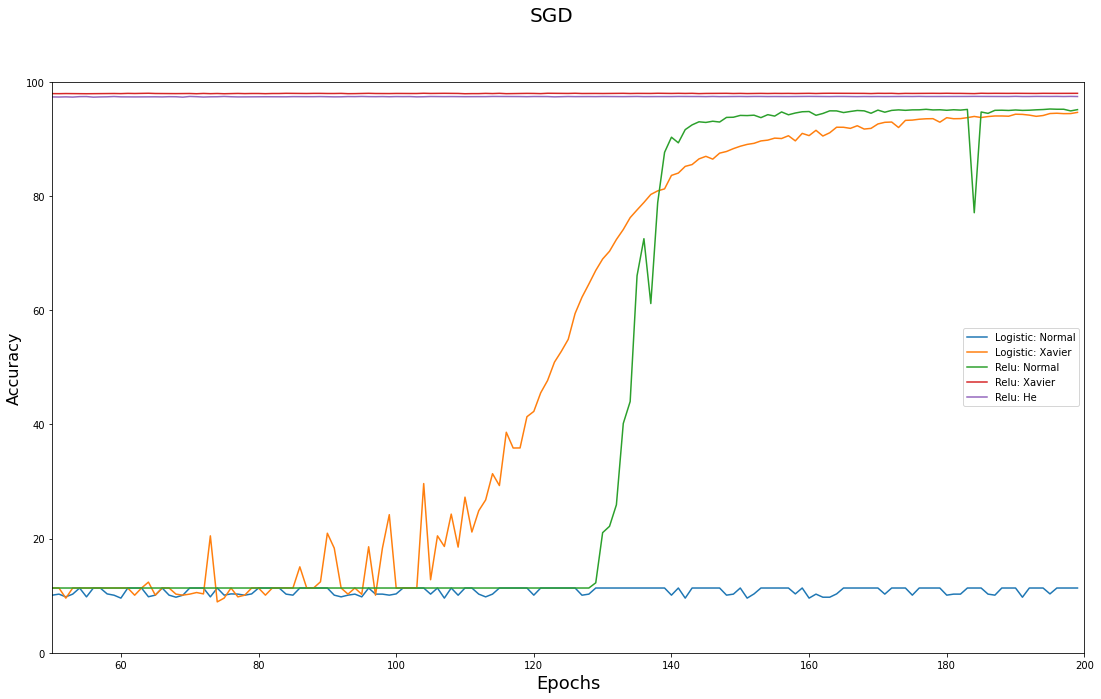

In [379]:
# plot SGD

labels = ['Logistic: Normal', 'Logistic: Xavier', 'Relu: Normal', 'Relu: Xavier', 'Relu: He']
x = np.arange(200)

#fig = plt.figure()
for i in range(len(labels)):
  plt.plot(x, sgd_res[i], label = labels[i])

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('SGD', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)

ax = plt.gca()
ax.set_xlim([50, 200])
ax.set_ylim([0, 100])

plt.legend()
plt.show()

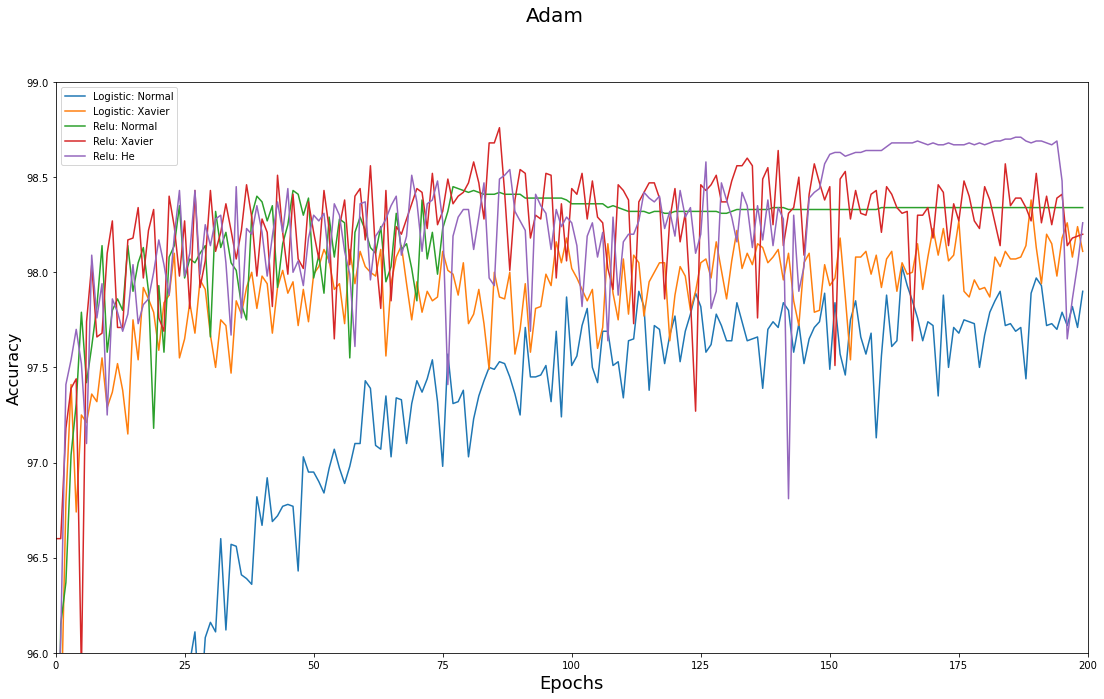

In [382]:
# plot Adam

labels = ['Logistic: Normal', 'Logistic: Xavier', 'Relu: Normal', 'Relu: Xavier', 'Relu: He']
x = np.arange(200)

for i in range(len(labels)):
  plt.plot(x, adam_res[i], label = labels[i])

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Adam', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 200])
ax.set_ylim([96, 99])

plt.legend()
plt.show()

Looking at my results, my graphs match those from the slides fairly well. In the SGD graph it can be seen that the Relu: Xavier and the Relu: He converging early at 98%. Indicating the effectiveness of weight initialization died to the model structure. The Relu: Normal had worse performance as expected. As opposed to the graph in the slides my Relu: Normal took another 50 epochs to converge, this could be due to the depth of my network, which might have more hidden units thus making backprop with a normal initialization and relu functions more difficult. The logistic normal and xavier performas expected. With the normal initialization not learning anything, and the xavier initialization converging around 150 epochs.

My adam results are fairly similar to the adam slide the professor gave as well. The Relu: He initialization perfromed best and achieved the highest accuracy. There was some drop in the final epoch, but this could just be a poor epoch performance as the model began overfitting. The two xavier initializations for relu and sigmoid were the next best performing as expected. My plots are fluctuating more than I expected, this I want to attribute to some overfitting and sensitvity to noise. Normalization or scaling of the input might help reduce this as well. The logistic normal is the worst performing as expected. A little unexpectedely my relu: normal instead of being the 2nd worse, achieved a higher accruacy around 98%. I would expect it to be worse due to the poor initialization, this might have happened due to the random initialization approximating the correct weights well.

### Problem 3: Dropout

Replicate the figures in M03 Adult Optimization, slide 40 using the details as follows:

For this one you will train four network instances with the same network architecture. Let’s use a larger one this time, to maximize the effect of dropout: 1024×5. It has to be a fully connected network again (a regular network, not a CNN or RNN).



Create four different networks that share the same architecture as follows:
1. Activation function: the logistic sigmoid function; initialization: Xavier initializer; no
dropout
2. Activation function: the logistic sigmoid function; initialization: Xavier initializer; with
dropout rate: 0.2 for the first layer and 0.5 for the other hidden layers
3. Activation function: ReLU; initialization: Kaiming He’s initializer; no dropout
4. Activation function: ReLU; initialization: Kaiming He’s initializer; with dropout rate: 0.2 for the first layer and 0.5 for the other hidden layers

In [391]:
len(mnist_train.targets)

60000

In [409]:
# scaling the inpu
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mnist_train.data.reshape(-1, 784))
scaled_data_test = scaler.transform(mnist_test.data.reshape(-1, 784))

dataset_train = TensorDataset( torch.tensor(scaled_data), torch.tensor(mnist_train.targets) )  
dataset_test = TensorDataset( torch.tensor(scaled_data_test), torch.tensor(mnist_test.targets) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [410]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(dataset_train,batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test,batch_size=100, shuffle=True)

In [411]:
class P3_Network_no_dropout(nn.Module):
    def __init__(self, activation):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(784, 1024)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.output = nn.Linear(1024, 10)
        
        if (activation == 'relu'):
          self.Activation = nn.ReLU()
          print("Using ReLU")
        else:
          self.Activation = nn.Sigmoid()
          print("Using Sigmoid")

        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.Activation(x)

        x = self.fc1(x)
        x = self.Activation(x)

        x = self.fc2(x)
        x = self.Activation(x)

        x = self.fc3(x)
        x = self.Activation(x)

        x = self.fc4(x)
        x = self.Activation(x)

        x = self.fc5(x)
        x = self.Activation(x)
        
        x = self.output(x)
        #x = F.log_softmax(x, dim = 1)
        
        return x

In [457]:
class P3_Network_dropout(nn.Module):
    def __init__(self, activation):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(784, 1024)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.output = nn.Linear(1024, 10)
        
        if (activation == 'relu'):
          self.Activation = nn.ReLU()
          print("Using ReLU")
        else:
          self.Activation = nn.Sigmoid()
          print("Using Sigmoid")

        self.dropout_f = nn.Dropout(p=0.2)

        self.dropout = nn.Dropout(p=0.5)

        
    def forward(self, x):
      
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.Activation(x)
        x = self.dropout_f(x)

        x = self.fc1(x)
        x = self.Activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.Activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.Activation(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.Activation(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = self.Activation(x)
        #x = self.dropout(x)
        
        x = self.output(x)
        #x = F.log_softmax(x, dim = 1)
        
        return x

In [458]:
def Build_Network_Init_Weights_3(activation, weight, dropout_bool):

  if (dropout_bool == True ):
    # Send model to GPU
    p3_model = P3_Network_dropout(activation).to(device)
  else:
    p3_model = P3_Network_no_dropout(activation).to(device)

  print(p3_model)

  # Define optimizer 
  optimizer = torch.optim.Adam(p3_model.parameters()) 

  def weight_init_xavier(m):
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight) # using uniform dists
        torch.nn.init.zeros_(m.bias) # fill bias with zeros

  def weight_init_he(m):
    
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = activation) # using uniform dists
        torch.nn.init.zeros_(m.bias) # fill bias with zeros

  if weight == 'xavier':
    print("Xavier Init")
    p3_model.apply(weight_init_xavier)
  else:
    print("He Init")
    p3_model.apply(weight_init_he)
  
  return p3_model, optimizer

In [459]:
# Define loss_func and hyperparameters

loss_func = nn.CrossEntropyLoss()

n_epochs = 400 # max_epochs

In [460]:
# Train Function
def train_3(amodel, optim):

  res_train_loss = []
  res_test_loss = []

  # Train parameters
  epoch = 1 # starting epoch
  log_interval = 5
  
  print("Training model")

  while ( (epoch <= n_epochs) ):
    
    # Training
    amodel.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      data_flattened = data.reshape(-1,784).to(device)
      batch_labels = target.to(device)

      # Forward pass
      batch_outputs = amodel(data_flattened.float())
      loss = loss_func(batch_outputs, batch_labels)

      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()

      train_loss += loss.item() # increment train loss for epoch

    # Evaluation 
    amodel.eval()
    lbl_list = []
    pred_list = []
    test_loss = 0 # calc test loss
    with torch.no_grad():
      for data, target in test_loader:
        
        test_flattened = data.reshape(-1, 784).to(device)
        test_batch_labels = target.to(device)

        # Forward pass
        test_outputs = amodel(test_flattened.float())
        loss = loss_func(test_outputs, test_batch_labels)

        test_batch_pred = F.softmax(test_outputs, dim = 1).argmax(dim=1, keepdim=True).cpu().numpy()
        lbl_list.append(test_batch_labels.cpu().numpy())
        pred_list.append(test_batch_pred)

        test_loss += loss.item() # increment test loss for epoch
        
    lbl_array = np.concatenate(lbl_list, axis=0)
    pred_array = np.concatenate(pred_list, axis=0)

    epoch_acc = accuracy_score(lbl_array,pred_array)

    per_sample_train_loss = train_loss/n_train
    per_sample_test_loss = test_loss/n_test

    res_train_loss.append(per_sample_train_loss)
    res_test_loss.append(per_sample_test_loss)
    
    # Logging
    if ( epoch % log_interval == 0 ) :
      print("Epoch: {}, Training Loss: {}, Test Loss: {}, Epoch Accuracy: {} \n ".format(epoch, per_sample_train_loss, per_sample_test_loss, epoch_acc))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  
  return res_train_loss, res_test_loss

In [415]:
log_res = []
relu_res = []


In [416]:

# Logistic Training 

# 'sigmoid', "xavier", False

p3_model, p3_optimizer = Build_Network_Init_Weights_3('sigmoid', "xavier", False)

train_res, test_res = train_3(p3_model, p3_optimizer)

log_res.append(train_res)
log_res.append(test_res)

Using Sigmoid
P3_Network_no_dropout(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (Activation): Sigmoid()
)
Xavier Init
Training model
Epoch: 5, Training Loss: 0.0008800195810229828, Test Loss: 0.0010098709944635629, Epoch Accuracy: 0.9706 
 
Epoch: 10, Training Loss: 0.0003798014931778501, Test Loss: 0.0010848418832290917, Epoch Accuracy: 0.9722 
 
Epoch: 15, Training Loss: 0.0002002512838887924, Test Loss: 0.0010421414372860454, Epoch Accuracy: 0.9777 
 
Epoch: 20, Training Loss: 0.0001369966103855404, Test Loss: 0.0009677893266125466, Epoch Accuracy: 0.9804 
 
Epoch: 25, Training Los

In [417]:
# 'sigmoid', "xavier", True

p3_model, p3_optimizer = Build_Network_Init_Weights_3('sigmoid', "xavier", True)

train_res, test_res = train_3(p3_model, p3_optimizer)

log_res.append(train_res)
log_res.append(test_res)

Using Sigmoid
P3_Network_dropout(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (Activation): Sigmoid()
  (dropout_f): Dropout(p=0.2, inplace=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Xavier Init
Training model
Epoch: 5, Training Loss: 0.0013500176722183823, Test Loss: 0.0011555720353033394, Epoch Accuracy: 0.9686 
 
Epoch: 10, Training Loss: 0.000684836796616825, Test Loss: 0.0009132097076391801, Epoch Accuracy: 0.9751 
 
Epoch: 15, Training Loss: 0.0004444042164211472, Test Loss: 0.0008662992881436366, Epoch Accuracy: 0.9805 
 
Epoch: 20, Training Loss: 0.00032754192915793585

In [484]:
relu_res = []

n_epochs = 200 # max_epochs

In [485]:
# 'relu', "he", False

p3_model, p3_optimizer = Build_Network_Init_Weights_3('relu', "he", False)

train_res, test_res = train_3(p3_model, p3_optimizer)

relu_res.append(train_res)
relu_res.append(test_res)

Using ReLU
P3_Network_no_dropout(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (Activation): ReLU()
)
He Init
Training model
Epoch: 5, Training Loss: 0.0005783621635317104, Test Loss: 0.0008926440416835249, Epoch Accuracy: 0.9772 
 
Epoch: 10, Training Loss: 0.0003385786562126062, Test Loss: 0.0010864511379040777, Epoch Accuracy: 0.981 
 
Epoch: 15, Training Loss: 0.00019612384611845452, Test Loss: 0.0012473292524489807, Epoch Accuracy: 0.9812 
 
Epoch: 20, Training Loss: 0.0001842267019786045, Test Loss: 0.001404605072492268, Epoch Accuracy: 0.9806 
 
Epoch: 25, Training Loss: 0.000113

In [486]:
# 'relu', "he", True

p3_model, p3_optimizer = Build_Network_Init_Weights_3('relu', "he", True)

train_res, test_res = train_3(p3_model, p3_optimizer)

relu_res.append(train_res)
relu_res.append(test_res)

Using ReLU
P3_Network_dropout(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=10, bias=True)
  (Activation): ReLU()
  (dropout_f): Dropout(p=0.2, inplace=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
He Init
Training model
Epoch: 5, Training Loss: 0.001154799652642881, Test Loss: 0.0010000196644105017, Epoch Accuracy: 0.976 
 
Epoch: 10, Training Loss: 0.0007683633367938455, Test Loss: 0.0011846294857561588, Epoch Accuracy: 0.9766 
 
Epoch: 15, Training Loss: 0.000646727554158618, Test Loss: 0.0011862286611343735, Epoch Accuracy: 0.9785 
 
Epoch: 20, Training Loss: 0.0005994311323828394, Test Loss: 

In [ ]:
log_res[0] = list(map(lambda x: x * 1000, log_res[0]))
log_res[2] = list(map(lambda x: x * 1000, log_res[2]))

In [487]:
relu_res[0] = list(map(lambda x: x * 1000, relu_res[0]))
relu_res[2] = list(map(lambda x: x * 1000, relu_res[2]))

In [489]:
# normalize output values
for i in range(len(relu_res)):
  relu_res[i] = [float(j)/max(relu_res[i]) for j in relu_res[i]]

In [421]:
# normalize output values
for i in range(len(log_res)):
  log_res[i] = [float(j)/max(log_res[i]) for j in log_res[i]]


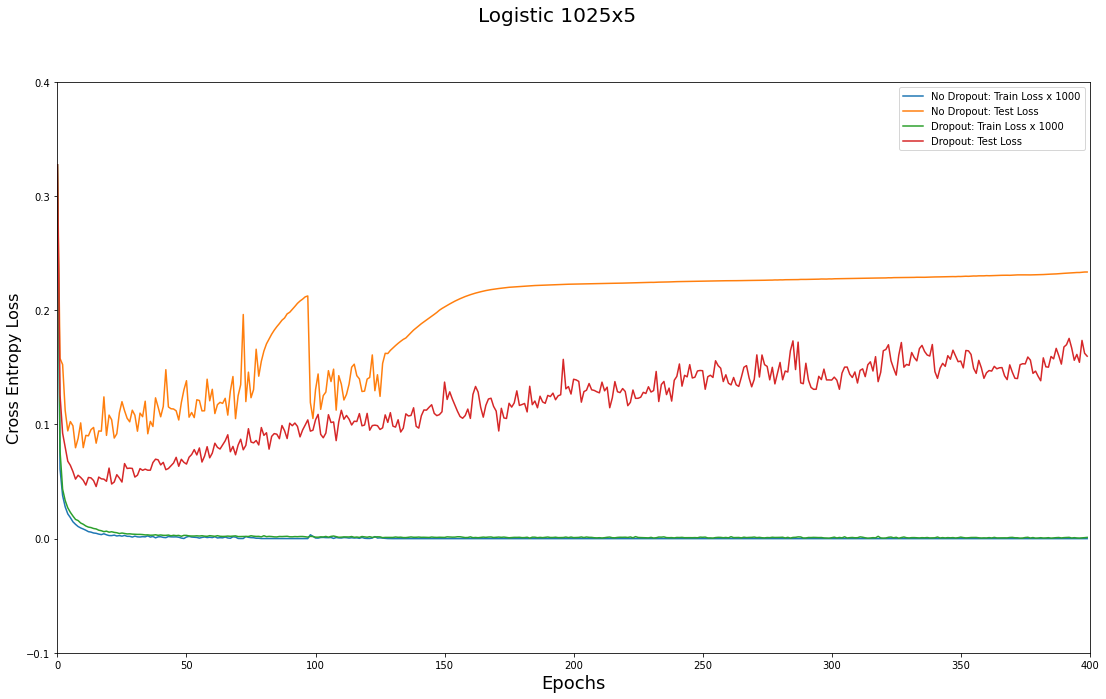

In [493]:
# plot Logisitc

labels = ['No Dropout: Train Loss x 1000', 'No Dropout: Test Loss', 'Dropout: Train Loss x 1000', 'Dropout: Test Loss']
x = np.arange(400)

for i in range(len(labels)):
  plt.plot(x, log_res[i], label = labels[i])

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Logistic 1025x5', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Cross Entropy Loss', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 400])
ax.set_ylim([-0.1, .4])

plt.legend()
plt.show()

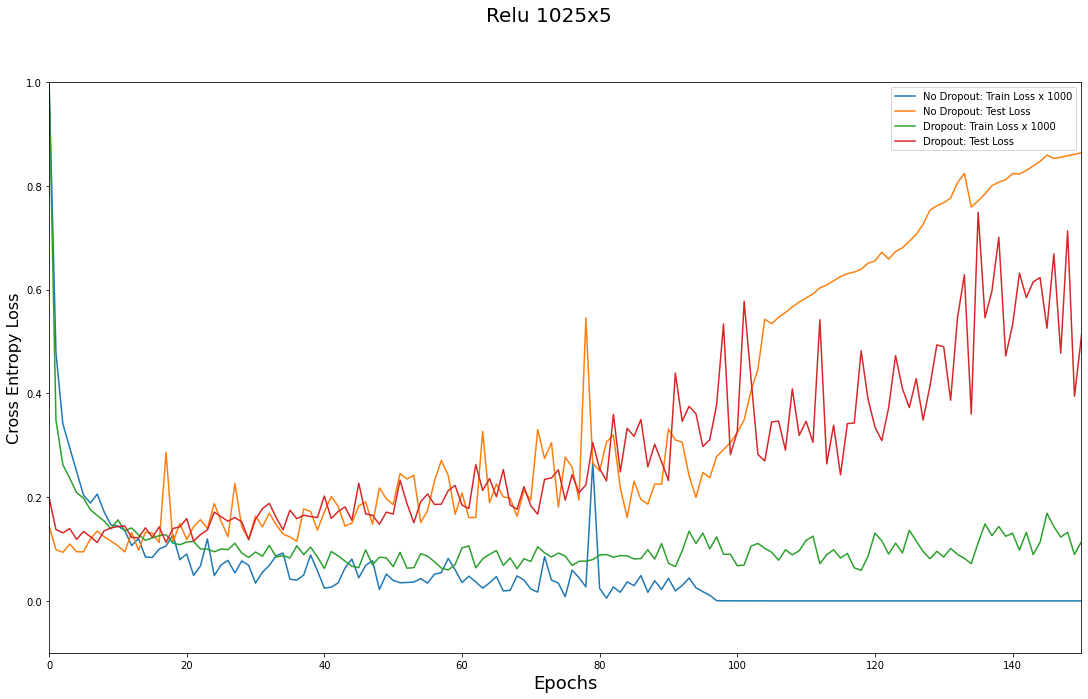

In [496]:

labels = ['No Dropout: Train Loss x 1000', 'No Dropout: Test Loss', 'Dropout: Train Loss x 1000', 'Dropout: Test Loss']
x = np.arange(200)

for i in range(len(labels)):
  plt.plot(x, relu_res[i], label = labels[i])

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.suptitle('Relu 1025x5', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Cross Entropy Loss', fontsize=16)

ax = plt.gca()
ax.set_xlim([0, 150])
ax.set_ylim([-0.1, 1.0])

plt.legend()
plt.show()

Looking at my results for Q3, My sigmoid graph matches the professor's slides fairly well. The dropout test loss is lower than the non-dropout test loss,as the dropout allows the model to generalize more effectively. The non-dropout train loss is lower than the dropout train loss, and it converges earlier. This is beacuse the dropout helps prevent overfitting the training data. My Relu graph also matches fairly well. The dropout test loss is lower than the non-dropout test loss again. The dropout train loss is higher than the non-dropout train loss as expected. The same trends can be seen for both activation functions.